In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
from scipy import stats
from math import ceil
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import seaborn as sns
import umap


from collections import Counter
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, enet_path
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles, venn3_unweighted
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

S_SIZE = 12
M_SIZE = 14
B_SIZE = 16

# plt.rc('font', size=S_SIZE)
# plt.rc('axes', titlesize=B_SIZE)
# plt.rc('axes', labelsize=M_SIZE)
# plt.rc('xtick', labelsize=S_SIZE)
# plt.rc('ytick', labelsize=S_SIZE)
# plt.rc('legend', fontsize=S_SIZE)
# plt.rc('figure', titlesize=B_SIZE)


Bad key text.latex.unicode in file C:\Users\S.Yoon\Anaconda3\envs\py36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file C:\Users\S.Yoon\Anaconda3\envs\py36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file C:\Users\S.Yoon\Anaconda3\envs\py36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need to get an updated matplotlibrc file fro

# Model Training Function

In [2]:
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    sum_sq = sum(diff**2)    
    n = len(y_pred)   
    
    return np.sqrt(sum_sq/n)

# sklearn model fitting
rmse_scorer = make_scorer(rmse, greater_is_better=False)

def train_model(model, param_grid=[], X=[], y=[], 
                splits=10, repeats=1):

    # get unmodified training data, unless data to use already specified
    if len(y)==0:
        X,y = get_training_data()
    
    # create cross-validation method
    rkfold = RepeatedKFold(n_splits=splits, n_repeats=repeats, random_state=123)
    
    # perform a grid search if param_grid given
    if len(param_grid)>0:
        # setup grid search parameters
        gsearch = GridSearchCV(model, param_grid, cv=rkfold,
                               scoring='r2',
                               verbose=True, return_train_score=True, n_jobs=4)

        gsearch.fit(X,y)

        model = gsearch.best_estimator_        
        best_idx = gsearch.best_index_

        # get cv-scores for best model
        grid_results = pd.DataFrame(gsearch.cv_results_)       
        cv_mean = abs(grid_results.loc[best_idx,'mean_test_score'])
        cv_std = grid_results.loc[best_idx,'std_test_score']

    # no grid search, just cross-val score for given model    
    else:
        grid_results = []
        cv_results = cross_val_score(model, X, y, scoring='r2', cv=rkfold)
        cv_mean = abs(np.mean(cv_results))
        cv_std = np.std(cv_results)
    
    # combine mean and std cv-score in to a pandas series
    cv_score = pd.Series({'mean':cv_mean,'std':cv_std})

    # predict y using the fitted model
    y_pred = model.predict(X)
    
    # print stats on model performance         
    print('----------------------')
    print(model)
    print('----------------------')
#     print('Total fitting R2 score=',model.score(X,y))
#     print('cross_val R2 mean=',cv_mean,', std=',cv_std)
    
    # residual plots
    y_pred = pd.Series(y_pred,index=y.index)
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    
    plt.figure(figsize=(12,4))
    ax_121 = plt.subplot(1,2,1)
    plt.plot(y_pred,y,'.')
    plt.xlabel('y')
    plt.ylabel('y_pred');
    plt.title('corr = {:.3f}'.format(np.corrcoef(y,y_pred)[0][1]))
    
    #cv_results = cross_val_predict(model, X, y, n_jobs = 4, cv=splits)
    
    ax_122=plt.subplot(1,2,2)
    plt.plot(y_pred,y-y_pred,'.')
    plt.ylim((-4,4))
    plt.xlabel('y_pred')
    plt.ylabel('y - y_pred');
    plt.title('std resid = {:.3f}'.format(std_resid))
    plt.show()

    return model, cv_score, grid_results

def get_cross_val_score(model, X=[], y=[], splits=5, repeats=1):
    # create cross-validation method
    rkfold = RepeatedKFold(n_splits=splits, n_repeats=repeats, random_state=123)
    # perform a grid search if param_grid given
    cv_results = cross_val_score(model, X, y, scoring='r2', cv=rkfold, n_jobs = 4)
    cv_mean = abs(np.mean(cv_results))
    cv_std = np.std(cv_results)
    print('cross_val: mean=',cv_mean,', std=',cv_std)
    return cv_mean

def get_cross_val_pred(model, X=[], y=[], splits=5):
    # create cross-validation method
    cv_results = cross_val_predict(model, X, y, n_jobs = 4, cv=splits)
    return cv_results

def Get_L1L2(alpha, l1r):
    L1 = alpha*l1r
    L2 = 0.5*alpha*(1-l1r)
    return [L1, L2]
    
def Get_AlphaL1r(L1, L2): 
    alpha = 2*L2 + L1
    l1r = 1 - 2*L2/alpha
    return [alpha,l1r]

opt_models = dict()
score_models = pd.DataFrame(columns=['mean','std'])

from sklearn.model_selection import KFold

def get_cross_val_prediction(model, X, y, N_split=5):
    kf = KFold(n_splits=N_split, shuffle=True)
    y_pred_list = []
    y_true_list = []
    pred_1d = []
    true_1d = []
    for train_index, test_index in kf.split(X.values):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        y_pred_list.append(y_pred.tolist())
        y_true_list.append(y_test.tolist())
        pred_1d += y_pred.tolist()
        true_1d += y_test.tolist()
    return y_pred_list, y_true_list, pred_1d, true_1d


# Loading Dataset - Define drug_list

In [7]:
f = "ctrp_processed.csv"
df_ctrp = pd.read_csv(f, index_col=0)

# f = "ebi_processed_ic50.csv"
# df_ebi = pd.read_csv(f, index_col=0)

# df_bootstrap_param = pd.read_csv('t_drugs_params_each.csv',index_col='drug')
# df_bootstrap_param


Ngenes = 18100
drug_total = list(df_ctrp.columns[Ngenes:])
c_drugs = ['PACLITAXEL','GEMCITABINE','DOCETAXEL','FLUOROURACIL','CYCLOPHOSPHAMIDE','OXALIPLATIN']
t_drugs = ['ERLOTINIB','DASATINIB','NILOTINIB','GEFITINIB','SORAFENIB','AFATINIB','BORTEZOMIB',\
           'OLAPARIB','IBRUTINIB','LAPATINIB','CRIZOTINIB']
h_drugs = ['FULVESTRANT']

drug_list = t_drugs
drug_list = ['ERLOTINIB']
Ndrugs = len(drug_list)

In [8]:
f = 'DASATINIB_selected_genes.csv'
df_genes = pd.read_csv(f, index_col=0)
df_genes

FLRT2    FBXO15   ZSCAN22    HMGXB3  \
22RV1_PROSTATE                -0.481377  0.149673  1.703455  0.659514   
2313287_STOMACH               -0.846677 -0.397325 -0.584215 -0.576520   
253JBV_URINARY_TRACT          -0.804177  1.309001 -1.393080  0.710691   
253J_URINARY_TRACT            -0.846677  0.633960 -1.019555 -0.595588   
42MGBA_CENTRAL_NERVOUS_SYSTEM  1.549633 -0.160103  0.211283  0.537295   
...                                 ...       ...       ...       ...   
YD8_UPPER_AERODIGESTIVE_TRACT  0.001763 -0.177552 -0.817252  1.096061   
YH13_CENTRAL_NERVOUS_SYSTEM    1.246457 -0.142778  1.567385  1.022280   
YKG1_CENTRAL_NERVOUS_SYSTEM    0.686165  1.518423  0.556844  0.532169   
ZR751_BREAST                  -0.717333  2.314913  0.749878  0.411420   
ZR7530_BREAST                 -0.838011 -0.681634  0.076048 -0.669801   

                                   RBFA      PCCB   SMPDL3A    FAM25G  \
22RV1_PROSTATE                 0.152580  0.763316  3.961483 -0.337557   
2313287_STOMACH               -0.740520  1.322957  1.997635 -0.337557   
253JBV_URINARY_TRACT           0.143818  0.452292  0.239142 -0.337557   
253J_URINARY_TRACT            -0.698499  0.308134  0.075731 -0.337557   
42MGBA_CENTRAL_NERVOUS_SYSTEM  0.341173 -1.872818 -0.975710 -0.337557   
...                                 ...       ...       ...       ...   
YD8_UPPER_AERODIGESTIVE_TRACT -1.136140 -0.279493  0.277291 -0.337557   
YH13_CENTRAL_NERVOUS_SYSTEM   -0.073688 -0.121004  0.464124 -0.337557   
YKG1_CENTRAL_NERVOUS_SYSTEM   -0.560367  0.825063  0.595573 -0.337557   
ZR751_BREAST                   1.203577  0.224403 -0.307107 -0.337557   
ZR7530_BREAST                 -0.977825 -0.305921 -0.072221 -0.337557   

                                  APOL4      MTTP  ...     THOP1     ESCO1  \
22RV1_PROSTATE                -0.408110 -0.085761  ... -0.083689  1.240913   
2313287_STOMACH               -0.408110 -0.066719  ... -1.110507  1.954646   
253JBV_URINARY_TRACT          -0.379414 -0.223840  ...  0.307847 -0.471977   
253J_URINARY_TRACT            -0.379414 -0.183504  ... -1.531292 -0.877741   
42MGBA_CENTRAL_NERVOUS_SYSTEM  0.514370 -0.371088  ...  0.331333 -0.346064   
...                                 ...       ...  ...       ...       ...   
YD8_UPPER_AERODIGESTIVE_TRACT -0.218234 -0.163608  ... -0.874614  1.010651   
YH13_CENTRAL_NERVOUS_SYSTEM   -0.351274 -0.415018  ... -0.423870  0.128158   
YKG1_CENTRAL_NERVOUS_SYSTEM    1.752035 -0.285754  ...  0.803374  0.131087   
ZR751_BREAST                   0.884507 -0.349444  ... -0.885029  2.562890   
ZR7530_BREAST                 -0.408110  0.026115  ... -1.021528 -1.624391   

                                  KRT17   SLC38A5      DGKH     LYZL1  \
22RV1_PROSTATE                -0.750411 -0.756734 -0.069530 -0.227520   
2313287_STOMACH                1.668245 -0.776895  0.065807 -0.227520   
253JBV_URINARY_TRACT          -0.630399 -0.611579  0.111912 -0.227520   
253J_URINARY_TRACT            -0.640770 -0.636415 -0.456806 -0.227520   
42MGBA_CENTRAL_NERVOUS_SYSTEM  0.395327 -0.707552  0.410743 -0.227520   
...                                 ...       ...       ...       ...   
YD8_UPPER_AERODIGESTIVE_TRACT  1.432828  0.244097  0.835334 -0.227520   
YH13_CENTRAL_NERVOUS_SYSTEM    0.780119  0.341372  0.857058 -0.227520   
YKG1_CENTRAL_NERVOUS_SYSTEM   -0.774615 -0.693269 -1.073770 -0.227520   
ZR751_BREAST                  -0.397133 -0.669138  1.661404 -0.227520   
ZR7530_BREAST                 -0.638154 -0.733483 -1.099338  1.909696   

                                 ZNF414     HACD4    LRRC28     HACD3  
22RV1_PROSTATE                 0.446529 -0.614129 -0.273409  1.451481  
2313287_STOMACH               -1.196936 -0.818929  1.078576  0.315298  
253JBV_URINARY_TRACT          -1.373553 -0.831944  0.036715  0.335134  
253J_URINARY_TRACT            -0.852218 -0.793250  0.038502  0.897997  
42MGBA_CENTRAL_NERVOUS_SYSTEM  0.378813 -0.806032  0.117327 -0.569698  
...                               

In [21]:
drug = "DASATINIB"
genes = list(df_genes.columns)
mask1 = ~df_ctrp.loc[:,drug].isna()
ctrp_x =  df_ctrp[mask1].iloc[:,:Ngenes]
out = scaler.fit_transform(ctrp_x)
ctrp_x = pd.DataFrame(out, columns=ctrp_x.columns, index=list(ctrp_x.index.values))
ctrp_x = ctrp_x.loc[:,genes]
ctrp_y = df_ctrp[mask1].loc[:,drug]

In [22]:
ctrp_x

FLRT2    FBXO15   ZSCAN22    HMGXB3  \
22RV1_PROSTATE                -0.481377  0.149673  1.703455  0.659514   
2313287_STOMACH               -0.846677 -0.397325 -0.584215 -0.576520   
253JBV_URINARY_TRACT          -0.804177  1.309001 -1.393080  0.710691   
253J_URINARY_TRACT            -0.846677  0.633960 -1.019555 -0.595588   
42MGBA_CENTRAL_NERVOUS_SYSTEM  1.549633 -0.160103  0.211283  0.537295   
...                                 ...       ...       ...       ...   
YD8_UPPER_AERODIGESTIVE_TRACT  0.001763 -0.177552 -0.817252  1.096061   
YH13_CENTRAL_NERVOUS_SYSTEM    1.246457 -0.142778  1.567385  1.022280   
YKG1_CENTRAL_NERVOUS_SYSTEM    0.686165  1.518423  0.556844  0.532169   
ZR751_BREAST                  -0.717333  2.314913  0.749878  0.411420   
ZR7530_BREAST                 -0.838011 -0.681634  0.076048 -0.669801   

                                   RBFA      PCCB   SMPDL3A    FAM25G  \
22RV1_PROSTATE                 0.152580  0.763316  3.961483 -0.337557   
2313287_STOMACH               -0.740520  1.322957  1.997635 -0.337557   
253JBV_URINARY_TRACT           0.143818  0.452292  0.239142 -0.337557   
253J_URINARY_TRACT            -0.698499  0.308134  0.075731 -0.337557   
42MGBA_CENTRAL_NERVOUS_SYSTEM  0.341173 -1.872818 -0.975710 -0.337557   
...                                 ...       ...       ...       ...   
YD8_UPPER_AERODIGESTIVE_TRACT -1.136140 -0.279493  0.277291 -0.337557   
YH13_CENTRAL_NERVOUS_SYSTEM   -0.073688 -0.121004  0.464124 -0.337557   
YKG1_CENTRAL_NERVOUS_SYSTEM   -0.560367  0.825063  0.595573 -0.337557   
ZR751_BREAST                   1.203577  0.224403 -0.307107 -0.337557   
ZR7530_BREAST                 -0.977825 -0.305921 -0.072221 -0.337557   

                                  APOL4      MTTP  ...     THOP1     ESCO1  \
22RV1_PROSTATE                -0.408110 -0.085761  ... -0.083689  1.240913   
2313287_STOMACH               -0.408110 -0.066719  ... -1.110507  1.954646   
253JBV_URINARY_TRACT          -0.379414 -0.223840  ...  0.307847 -0.471977   
253J_URINARY_TRACT            -0.379414 -0.183504  ... -1.531292 -0.877741   
42MGBA_CENTRAL_NERVOUS_SYSTEM  0.514370 -0.371088  ...  0.331333 -0.346064   
...                                 ...       ...  ...       ...       ...   
YD8_UPPER_AERODIGESTIVE_TRACT -0.218234 -0.163608  ... -0.874614  1.010651   
YH13_CENTRAL_NERVOUS_SYSTEM   -0.351274 -0.415018  ... -0.423870  0.128158   
YKG1_CENTRAL_NERVOUS_SYSTEM    1.752035 -0.285754  ...  0.803374  0.131087   
ZR751_BREAST                   0.884507 -0.349444  ... -0.885029  2.562890   
ZR7530_BREAST                 -0.408110  0.026115  ... -1.021528 -1.624391   

                                  KRT17   SLC38A5      DGKH     LYZL1  \
22RV1_PROSTATE                -0.750411 -0.756734 -0.069530 -0.227520   
2313287_STOMACH                1.668245 -0.776895  0.065807 -0.227520   
253JBV_URINARY_TRACT          -0.630399 -0.611579  0.111912 -0.227520   
253J_URINARY_TRACT            -0.640770 -0.636415 -0.456806 -0.227520   
42MGBA_CENTRAL_NERVOUS_SYSTEM  0.395327 -0.707552  0.410743 -0.227520   
...                                 ...       ...       ...       ...   
YD8_UPPER_AERODIGESTIVE_TRACT  1.432828  0.244097  0.835334 -0.227520   
YH13_CENTRAL_NERVOUS_SYSTEM    0.780119  0.341372  0.857058 -0.227520   
YKG1_CENTRAL_NERVOUS_SYSTEM   -0.774615 -0.693269 -1.073770 -0.227520   
ZR751_BREAST                  -0.397133 -0.669138  1.661404 -0.227520   
ZR7530_BREAST                 -0.638154 -0.733483 -1.099338  1.909696   

                                 ZNF414     HACD4    LRRC28     HACD3  
22RV1_PROSTATE                 0.446529 -0.614129 -0.273409  1.451481  
2313287_STOMACH               -1.196936 -0.818929  1.078576  0.315298  
253JBV_URINARY_TRACT          -1.373553 -0.831944  0.036715  0.335134  
253J_URINARY_TRACT            -0.852218 -0.793250  0.038502  0.897997  
42MGBA_CENTRAL_NERVOUS_SYSTEM  0.378813 -0.806032  0.117327 -0.569698  
...                               

In [16]:
drug_list = ["DASATINIB"]

=================      CTRP      =================
=========  Drug = DASATINIB, NGenes = 10  =========
Fitting 25 folds for each of 149 candidates, totalling 3725 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 3718 out of 3725 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 3725 out of 3725 | elapsed:    4.8s finished


----------------------
Ridge(alpha=88, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


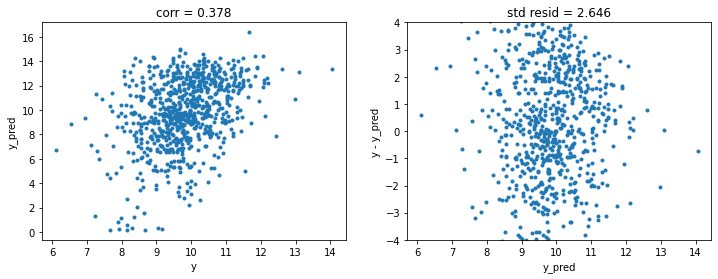

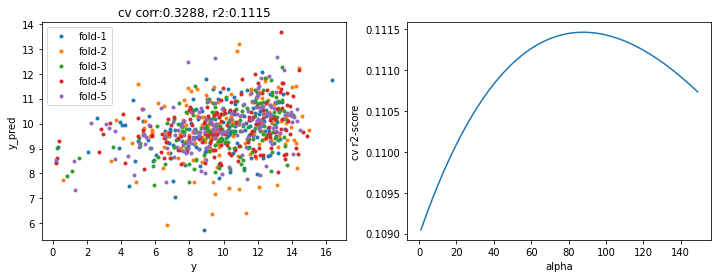

ok
=================      CTRP      =================
=========  Drug = DASATINIB, NGenes = 75  =========
Fitting 25 folds for each of 149 candidates, totalling 3725 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  95 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 3718 out of 3725 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 3725 out of 3725 | elapsed:    5.5s finished


----------------------
Ridge(alpha=149, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


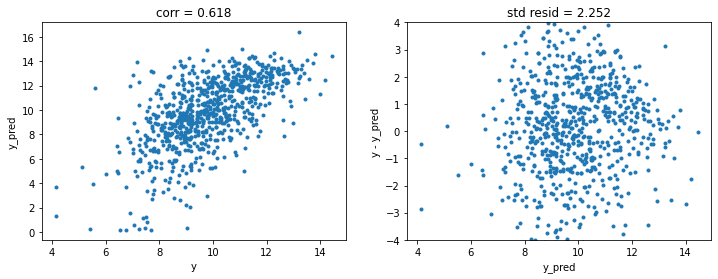

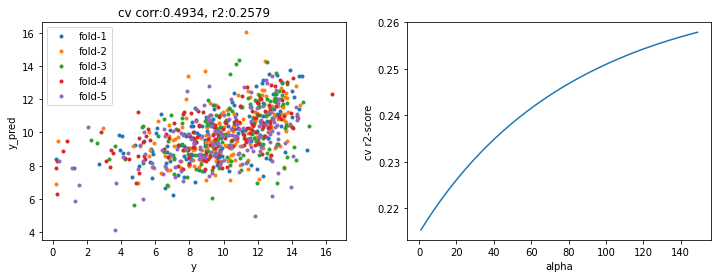

ok
=================      CTRP      =================
=========  Drug = DASATINIB, NGenes = 141  =========
Fitting 25 folds for each of 149 candidates, totalling 3725 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    1.5s


----------------------
Ridge(alpha=149, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3725 out of 3725 | elapsed:    6.8s finished


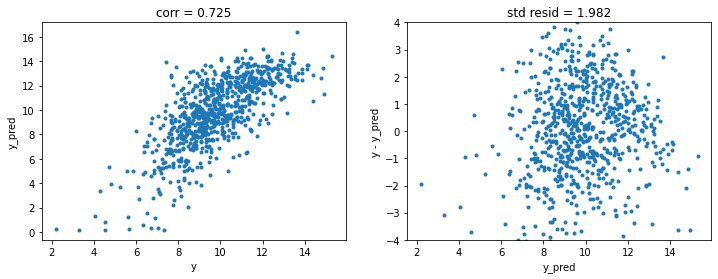

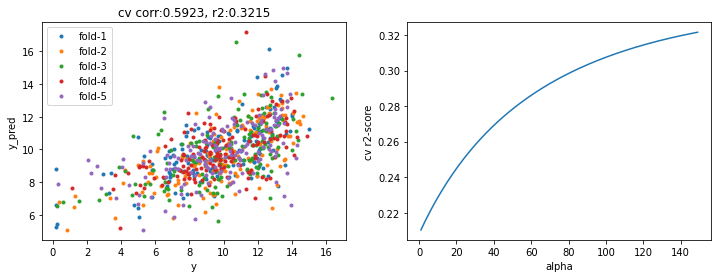

ok
=================      CTRP      =================
=========  Drug = DASATINIB, NGenes = 206  =========
Fitting 25 folds for each of 149 candidates, totalling 3725 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.5s


----------------------
Ridge(alpha=149, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3725 out of 3725 | elapsed:    8.3s finished


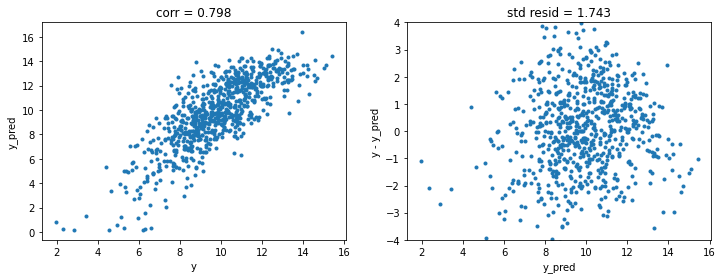

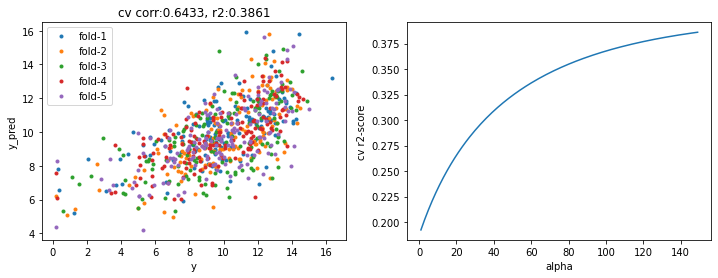

ok
=================      CTRP      =================
=========  Drug = DASATINIB, NGenes = 272  =========
Fitting 25 folds for each of 149 candidates, totalling 3725 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 2380 tasks      | elapsed:    6.9s


----------------------
Ridge(alpha=149, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3725 out of 3725 | elapsed:   10.2s finished


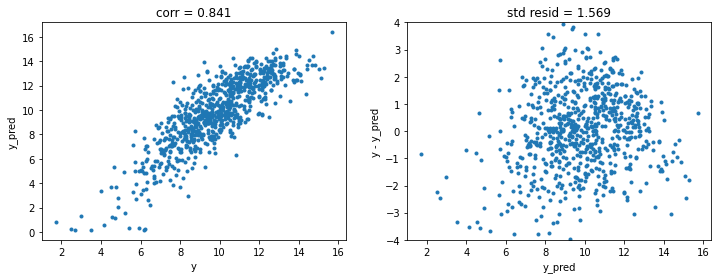

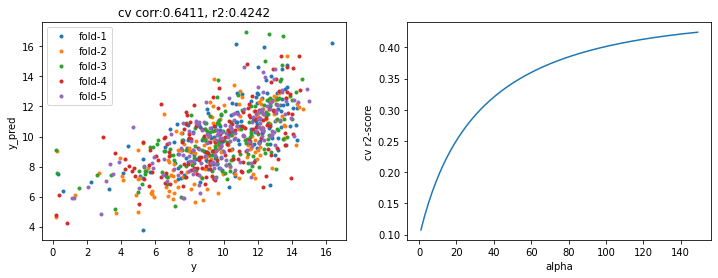

ok
=================      CTRP      =================
=========  Drug = DASATINIB, NGenes = 338  =========
Fitting 25 folds for each of 149 candidates, totalling 3725 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 2380 tasks      | elapsed:    8.5s


----------------------
Ridge(alpha=149, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3725 out of 3725 | elapsed:   12.4s finished


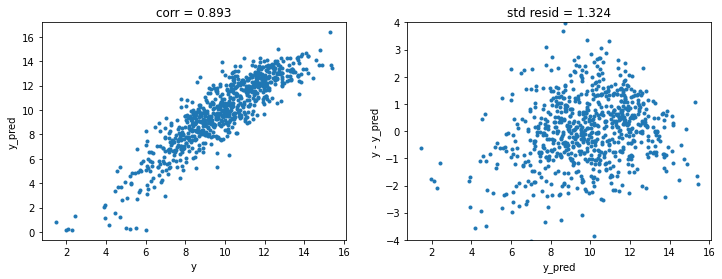

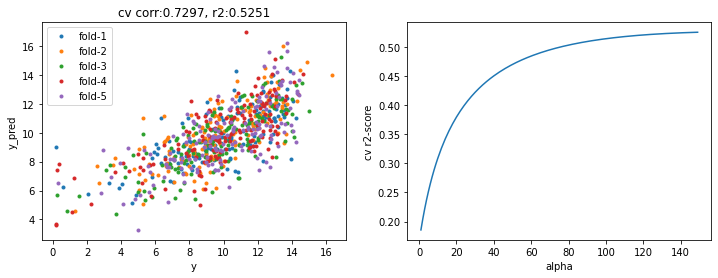

ok
=================      CTRP      =================
=========  Drug = DASATINIB, NGenes = 403  =========
Fitting 25 folds for each of 149 candidates, totalling 3725 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 2380 tasks      | elapsed:   10.1s


----------------------
Ridge(alpha=149, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3725 out of 3725 | elapsed:   15.2s finished


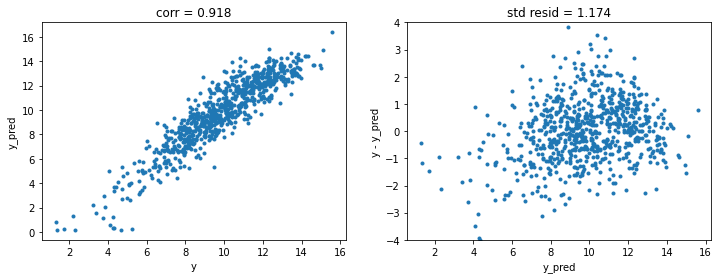

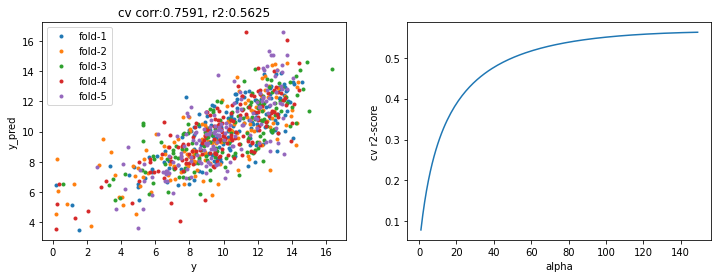

ok
=================      CTRP      =================
=========  Drug = DASATINIB, NGenes = 469  =========
Fitting 25 folds for each of 149 candidates, totalling 3725 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 1260 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 3260 tasks      | elapsed:   16.4s


----------------------
Ridge(alpha=115, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3725 out of 3725 | elapsed:   18.6s finished


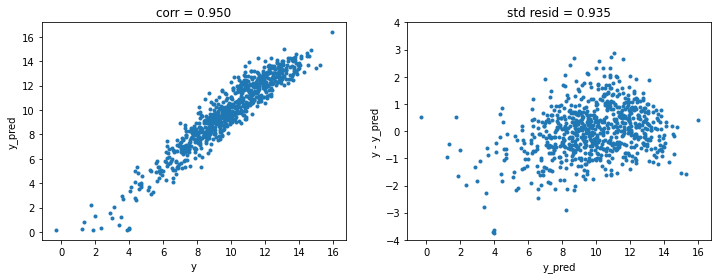

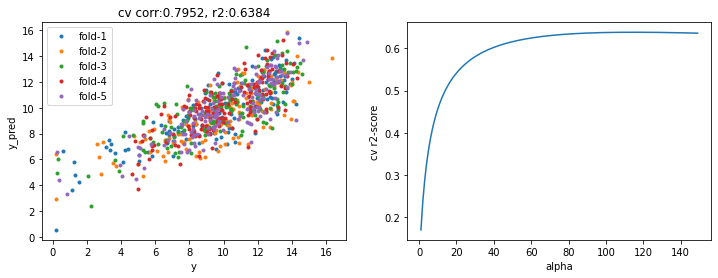

ok
=================      CTRP      =================
=========  Drug = DASATINIB, NGenes = 535  =========
Fitting 25 folds for each of 149 candidates, totalling 3725 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 1288 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done 3288 tasks      | elapsed:   19.7s
[Parallel(n_jobs=4)]: Done 3725 out of 3725 | elapsed:   21.9s finished


----------------------
Ridge(alpha=102, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


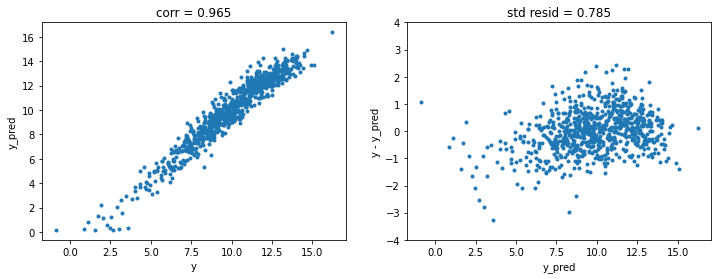

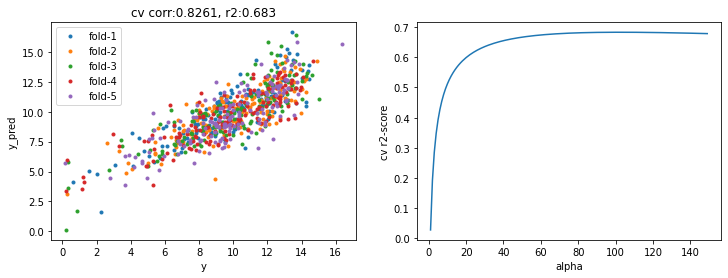

ok
=================      CTRP      =================
=========  Drug = DASATINIB, NGenes = 600  =========
Fitting 25 folds for each of 149 candidates, totalling 3725 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 1260 tasks      | elapsed:    9.2s
[Parallel(n_jobs=4)]: Done 3260 tasks      | elapsed:   22.0s


----------------------
Ridge(alpha=56, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3725 out of 3725 | elapsed:   25.0s finished


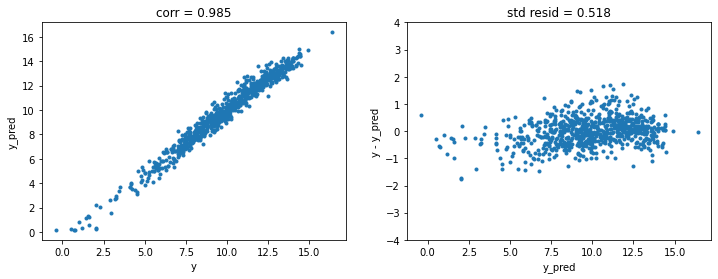

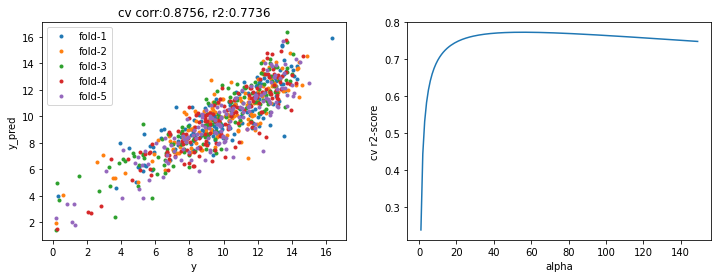

ok
=================      CTRP      =================
=========  Drug = DASATINIB, NGenes = 666  =========
Fitting 25 folds for each of 149 candidates, totalling 3725 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 1260 tasks      | elapsed:    9.8s
[Parallel(n_jobs=4)]: Done 3260 tasks      | elapsed:   23.5s


----------------------
Ridge(alpha=35, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3725 out of 3725 | elapsed:   26.6s finished


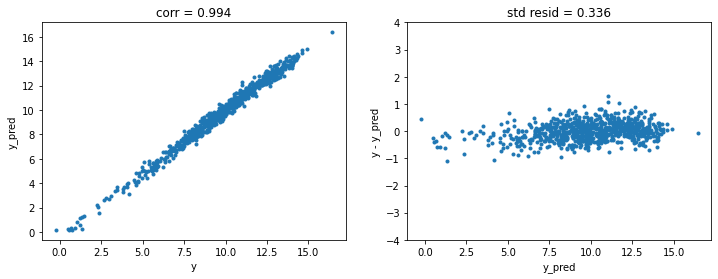

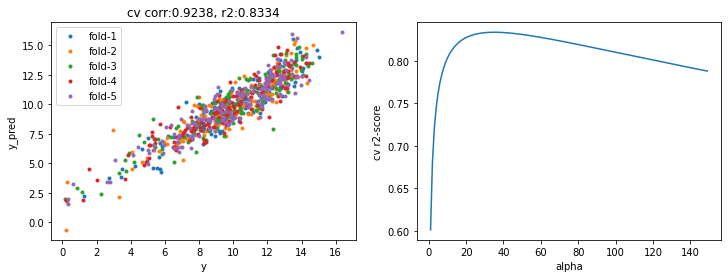

ok
=================      CTRP      =================
=========  Drug = DASATINIB, NGenes = 732  =========
Fitting 25 folds for each of 149 candidates, totalling 3725 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 1260 tasks      | elapsed:   10.4s
[Parallel(n_jobs=4)]: Done 3260 tasks      | elapsed:   24.6s


----------------------
Ridge(alpha=6, copy_X=True, fit_intercept=True, max_iter=10000, normalize=False,
      random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3725 out of 3725 | elapsed:   27.9s finished


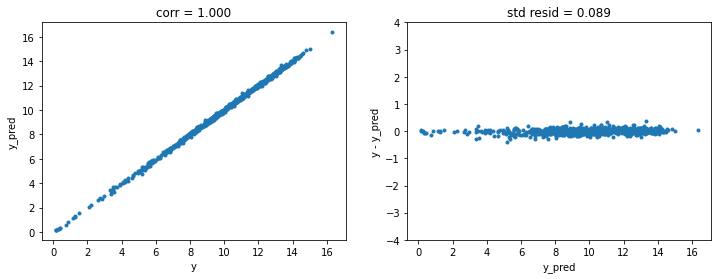

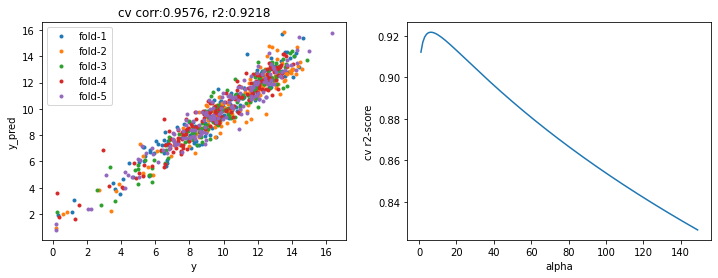

ok


In [23]:
splits = 5
repeats = 5


for drug in drug_list:

   
    ctrp_loop = np.linspace(10,len(genes),12, dtype=int)

   
    model = Ridge(max_iter=10000)
    alph_range = np.arange(1,150,1)
    param_grid = {'alpha': alph_range}

    for Sel_NGene in ctrp_loop:
        Genes = genes[:Sel_NGene]
        print("=================      CTRP      =================")
        print('=========  Drug = {}, NGenes = {}  ========='.format(drug, Sel_NGene))
        x = ctrp_x.loc[:,Genes]
        y = ctrp_y
        best_model,cv_score,grid_results = train_model(model, param_grid=param_grid, splits=splits, repeats=repeats, X=x, y=y)
        cv_r2 = cv_score['mean']
        cv_r2 = np.around(cv_r2,4)
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        #y_pred = get_cross_val_pred(best_model,X=x, y=y)
        y_pred_list, y_true_list, y_pred, y = get_cross_val_prediction(best_model,X=x,y=y)
        corr = np.corrcoef(x=y_pred, y=y)
        corr = np.around(corr[0,1],4)
        plt.plot(y_true_list[0],y_pred_list[0],'.',label='fold-1')
        plt.plot(y_true_list[1],y_pred_list[1],'.',label='fold-2')
        plt.plot(y_true_list[2],y_pred_list[2],'.',label='fold-3')
        plt.plot(y_true_list[3],y_pred_list[3],'.',label='fold-4')
        plt.plot(y_true_list[4],y_pred_list[4],'.',label='fold-5')
        plt.legend()
        plt.xlabel('y')
        plt.ylabel('y_pred')
        plt.title('cv corr:{}, r2:{}'.format(corr,cv_r2))
        plt.subplot(1,2,2)
        plt.plot(alph_range, abs(grid_results['mean_test_score']))
        plt.xlabel('alpha')
        plt.ylabel('cv r2-score')
        plt.show()
        print('ok')

   




# Bootstrap Sampling

In [10]:
random_state = 777
boot_res_df_cols = []
for drug in drug_list:
    boot_res_df_cols.append(drug)
    boot_res_df_cols.append(drug+'-'+'Gcount')
df_ctrp_genes = pd.DataFrame(columns=boot_res_df_cols, index=range(500))
df_ebi_genes = pd.DataFrame(columns=boot_res_df_cols, index=range(500))

df_bootstrap_param = pd.read_csv('t_drugs_params_each.csv',index_col='drug')
df_bootstrap_param

NBootstrap = 1000
for drug in drug_list:
    print('drug = {}'.format(drug))
    mask1 = ~df_ctrp.loc[:,drug].isna()
    ctrp_x =  df_ctrp[mask1].iloc[:,:Ngenes]
    out = scaler.fit_transform(ctrp_x)
    ctrp_x = pd.DataFrame(out, columns=ctrp_x.columns, index=list(ctrp_x.index.values))
    ctrp_y = df_ctrp[mask1].loc[:,drug]

    mask2 = ~df_ebi.loc[:,drug].isna()
    ebi_x =  df_ebi[mask2].iloc[:,:Ngenes]
    out = scaler.fit_transform(ebi_x)
    ebi_x = pd.DataFrame(out, columns=ebi_x.columns, index=list(ebi_x.index.values))
    ebi_y = df_ebi[mask2].loc[:,drug]
    
    x = ctrp_x
    y = ctrp_y
    total = pd.merge(x,y.rename('y'), left_index=True, right_index=True)
    Nsamples = total.shape[0]
    model_alpha = df_bootstrap_param.loc[drug,'ctrp_alpha']
    model_l1ratio = df_bootstrap_param.loc[drug,'ctrp_l1ratio']
    
    model = ElasticNet(max_iter=10000, alpha=model_alpha, l1_ratio=model_l1ratio,\
                           random_state = random_state)
    g_counter_list = []
    print('ElasticNet with Bootstrap Sampling start!-CTRP')
    for i in range(NBootstrap):
        bootsampling = total.sample(n=Nsamples, replace=True)
        b_x = bootsampling.iloc[:,:Ngenes]
        b_y = bootsampling.iloc[:,-1]
        model.fit(b_x,b_y)
        en_coefs = pd.Series(model.coef_,index=x.columns)
        g_counter_list += list(en_coefs[en_coefs!=0].index)
        if i%100 == 0:
            print("Current i = {}".format(i))
    res = pd.DataFrame.from_dict(Counter(g_counter_list), orient='index')
    genes = list(res[0].sort_values(ascending=False).head(500).index)
    coutns = list(res[0].sort_values(ascending=False).head(500).values)
    df_ctrp_genes.loc[:,drug] = genes
    df_ctrp_genes.loc[:,drug+'-'+'Gcount'] = coutns
    
    
    x = ebi_x
    y = ebi_y
    total = pd.merge(x,y.rename('y'), left_index=True, right_index=True)
    Nsamples = total.shape[0]
    model_alpha = df_bootstrap_param.loc[drug,'ebi_alpha']
    model_l1ratio = df_bootstrap_param.loc[drug,'ebi_l1ratio']
    
    model = ElasticNet(max_iter=10000, alpha=model_alpha, l1_ratio=model_l1ratio,\
                           random_state = random_state)
    g_counter_list = []
    print('ElasticNet with Bootstrap Sampling start!-EBI')
    for i in range(NBootstrap):
        bootsampling = total.sample(n=Nsamples, replace=True)
        b_x = bootsampling.iloc[:,:Ngenes]
        b_y = bootsampling.iloc[:,-1]
        model.fit(b_x,b_y)
        en_coefs = pd.Series(model.coef_,index=x.columns)
        g_counter_list += list(en_coefs[en_coefs!=0].index)
        if i%100 == 0:
            print("Current i = {}".format(i))
    res = pd.DataFrame.from_dict(Counter(g_counter_list), orient='index')
    genes = list(res[0].sort_values(ascending=False).head(500).index)
    coutns = list(res[0].sort_values(ascending=False).head(500).values)
    df_ebi_genes.loc[:,drug] = genes
    df_ebi_genes.loc[:,drug+'-'+'Gcount'] = coutns
        
print('Done!')


f = 'Bootstrap_Genes_ctrp_tdrug_new.csv'
df_ctrp_genes.to_csv(f, na_rep=np.nan)
f = 'Bootstrap_Genes_ebi_tdrug_new.csv'
df_ebi_genes.to_csv(f, na_rep=np.nan)
print('Saving Res Done!')

drug = ERLOTINIB
ElasticNet with Bootstrap Sampling start!-CTRP
Current i = 0
Current i = 100
Current i = 200
Current i = 300
Current i = 400
Current i = 500
Current i = 600
Current i = 700
Current i = 800
Current i = 900
ElasticNet with Bootstrap Sampling start!-EBI
Current i = 0
Current i = 100
Current i = 200
Current i = 300
Current i = 400
Current i = 500
Current i = 600
Current i = 700
Current i = 800
Current i = 900
Done!
Saving Res Done!


# Sorting Gene Importance

Current durg = ERLOTINIB,  1/1
Fitting 50 folds for each of 126 candidates, totalling 6300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 472 tasks      | elapsed:   21.1s
[Parallel(n_jobs=4)]: Done 1172 tasks      | elapsed:   36.4s
[Parallel(n_jobs=4)]: Done 2072 tasks      | elapsed:   50.9s
[Parallel(n_jobs=4)]: Done 3676 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 6300 out of 6300 | elapsed:  1.7min finished


----------------------
ElasticNet(alpha=0.5, copy_X=True, fit_intercept=True, l1_ratio=0.01,
           max_iter=10000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
----------------------


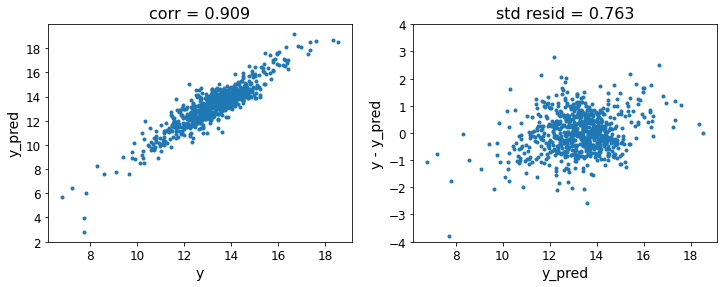

440 non-zero coefficients (ctrp)
---------------------------------------
Fitting 50 folds for each of 126 candidates, totalling 6300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 360 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done 2312 tasks      | elapsed:   17.9s


----------------------
ElasticNet(alpha=0.6, copy_X=True, fit_intercept=True, l1_ratio=0.01,
           max_iter=10000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
----------------------


[Parallel(n_jobs=4)]: Done 6300 out of 6300 | elapsed:   30.6s finished


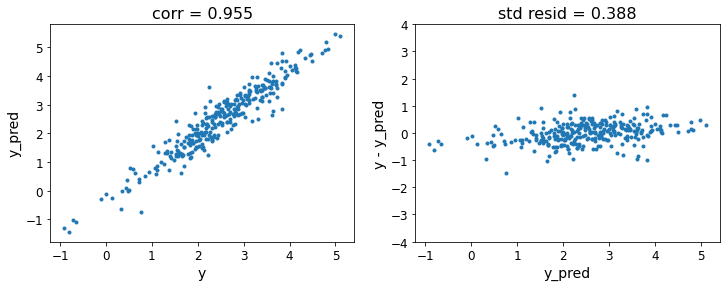

400 non-zero coefficients (EBI)
---------------------------------------


In [13]:
sorted_genes_cols = []
for drug in drug_list:
    sorted_genes_cols.append(drug+'-ctrp')
    sorted_genes_cols.append(drug+'-ebi')
df_sorted_genes = pd.DataFrame(columns=sorted_genes_cols, index=range(500))

f='Bootstrap_Genes_ctrp_tdrug_new.csv'
ctrp_genes = pd.read_csv(f, index_col=0)
f='Bootstrap_Genes_ebi_tdrug_new.csv'
ebi_genes = pd.read_csv(f, index_col=0)

splits = 10
repeats = 5
cnt = 0
total_len = len(drug_list)
for drug in drug_list:
    cnt += 1
    print('Current durg = {},  {}/{}'.format(drug,cnt,total_len))
    ctrp_sgenes = list(ctrp_genes[drug])
    ebi_sgenes = list(ebi_genes[drug])

    mask1 = ~df_ctrp.loc[:,drug].isna()
    ctrp_x =  df_ctrp[mask1].iloc[:,:Ngenes]
    out = scaler.fit_transform(ctrp_x)
    ctrp_x = pd.DataFrame(out, columns=ctrp_x.columns, index=list(ctrp_x.index.values))
    ctrp_x =  ctrp_x.loc[:,ctrp_sgenes]
    ctrp_y = df_ctrp[mask1].loc[:,drug]

    mask2 = ~df_ebi.loc[:,drug].isna()
    ebi_x =  df_ebi[mask2].iloc[:,:Ngenes]
    out = scaler.fit_transform(ebi_x)
    ebi_x = pd.DataFrame(out, columns=ebi_x.columns, index=list(ebi_x.index.values))
    ebi_x =  ebi_x.loc[:,ebi_sgenes]
    ebi_y = df_ebi[mask2].loc[:,drug]

    
    alpha_range = np.arange(0.1,1.5,0.1)
    l1_ratio = np.arange(0.01,0.1,0.01)
    param_grid = {'alpha': alpha_range,
                  'l1_ratio': l1_ratio,
                  'max_iter':[10000]}
    
    model = ElasticNet()
    model,cv_score,grid_results = train_model(model, param_grid=param_grid, 
                                                  splits=splits, repeats=repeats, X=ctrp_x, y=ctrp_y)
    ctrp_alpha = model.alpha
    ctrp_l1 = model.l1_ratio
    ctrp_score = cv_score['mean']
    en_coefs = pd.Series(model.coef_,index=ctrp_x.columns)
    #print(sum(en_coefs==0),'zero coefficients')
    print(sum(en_coefs!=0),'non-zero coefficients (ctrp)')
    print('---------------------------------------')
    ctrp_sorted_genes = list(en_coefs[en_coefs!=0].abs().sort_values(ascending=False).index)
    Nctrp = len(ctrp_sorted_genes)
    ctrp_sorted_genes = ctrp_sorted_genes + [np.nan]*(500-Nctrp)

    
    model = ElasticNet()
    model,cv_score,grid_results = train_model(model, param_grid=param_grid, 
                                                  splits=splits, repeats=repeats, X=ebi_x, y=ebi_y)
    ebi_alpha = model.alpha
    ebi_l1 = model.l1_ratio
    ebi_score = cv_score['mean']

    en_coefs = pd.Series(model.coef_,index=ebi_x.columns)
    #print(sum(en_coefs==0),'zero coefficients')
    print(sum(en_coefs!=0),'non-zero coefficients (EBI)')
    print('---------------------------------------')
    ebi_sorted_genes = list(en_coefs[en_coefs!=0].abs().sort_values(ascending=False).index)
    Nebi = len(ebi_sorted_genes)
    ebi_sorted_genes = ebi_sorted_genes + [np.nan]*(500-Nebi)
    
    df_sorted_genes.loc[:,drug+'-ctrp'] = ctrp_sorted_genes
    df_sorted_genes.loc[:,drug+'-ebi'] = ebi_sorted_genes
   

    
f = 'each_genes_sorted_tdrug_new.csv'
df_sorted_genes.to_csv(f)

In [14]:
f = 'each_genes_sorted_tdrug_new.csv'
df_sorted_genes.to_csv(f)

# CV R2 - ElasticNet(s)

In [15]:
f="each_genes_sorted_tdrug_new.csv"
cv_res_df = pd.read_csv(f, index_col=0)
index_ = list(np.arange(500))
res_df_cols = []
for drug in drug_list:
    res_df_cols.append(drug+'-'+'ctrp')
    res_df_cols.append(drug+'-'+'ebi')
cv_r2_df = pd.DataFrame(columns=res_df_cols, index=index_)


In [16]:
cv_r2_df

ERLOTINIB-ctrp ERLOTINIB-ebi
0              NaN           NaN
1              NaN           NaN
2              NaN           NaN
3              NaN           NaN
4              NaN           NaN
..             ...           ...
495            NaN           NaN
496            NaN           NaN
497            NaN           NaN
498            NaN           NaN
499            NaN           NaN

[500 rows x 2 columns]

=================      CTRP      =================
=========  Drug = ERLOTINIB, NGenes = 10  =========
Fitting 25 folds for each of 145 candidates, totalling 3625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 3625 out of 3625 | elapsed:    4.6s finished


----------------------
Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


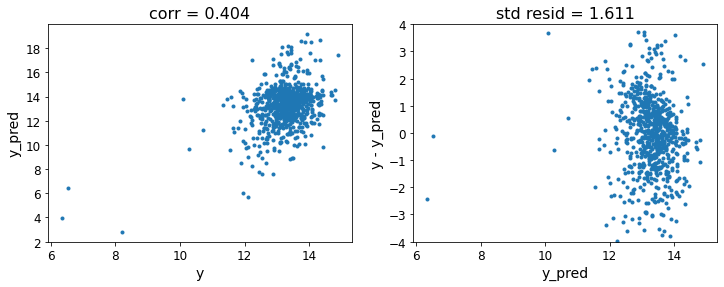

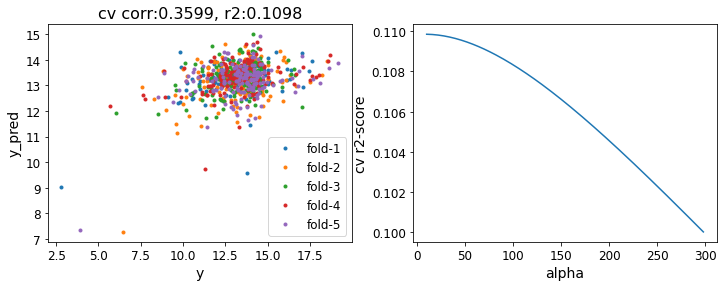

ok
=================      CTRP      =================
=========  Drug = ERLOTINIB, NGenes = 49  =========
Fitting 25 folds for each of 145 candidates, totalling 3625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.3s


----------------------
Ridge(alpha=86, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3625 out of 3625 | elapsed:    5.0s finished


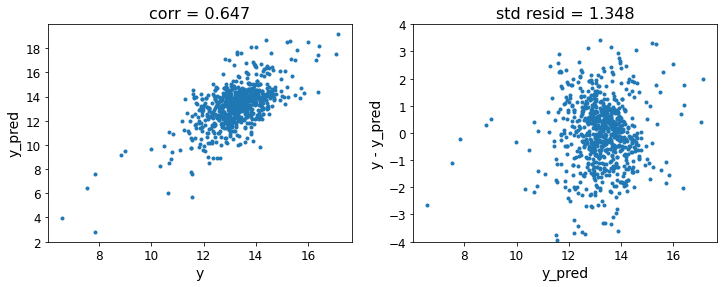

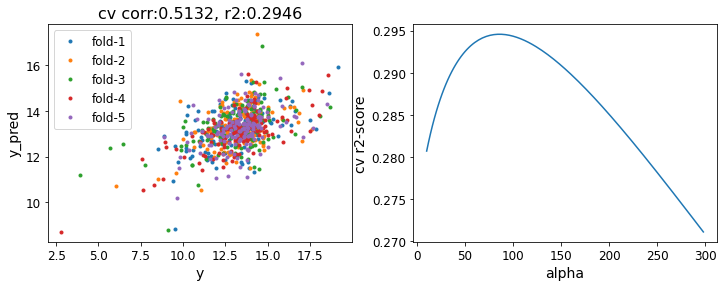

ok
=================      CTRP      =================
=========  Drug = ERLOTINIB, NGenes = 88  =========
Fitting 25 folds for each of 145 candidates, totalling 3625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    1.4s


----------------------
Ridge(alpha=88, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3625 out of 3625 | elapsed:    5.3s finished


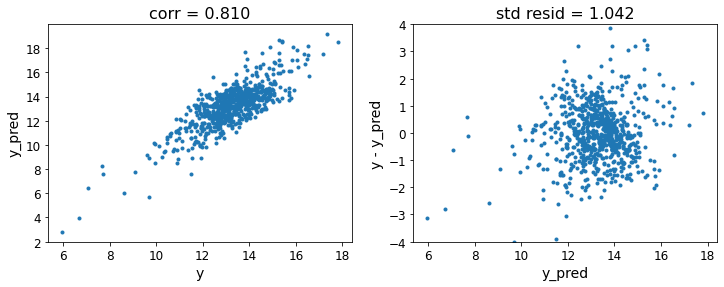

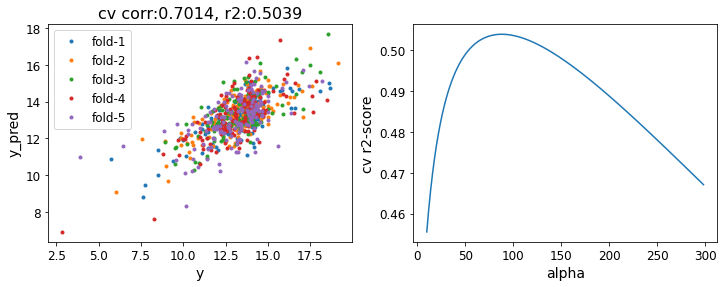

ok
=================      CTRP      =================
=========  Drug = ERLOTINIB, NGenes = 127  =========
Fitting 25 folds for each of 145 candidates, totalling 3625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.4s


----------------------
Ridge(alpha=86, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3625 out of 3625 | elapsed:    6.1s finished


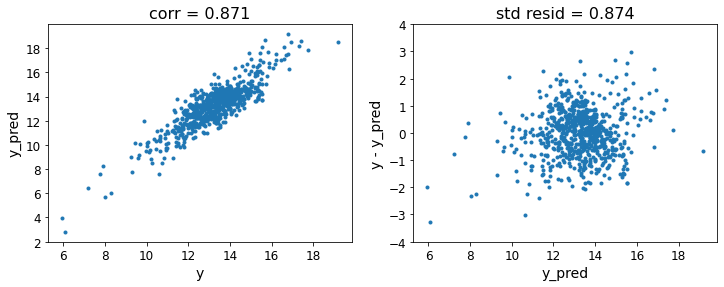

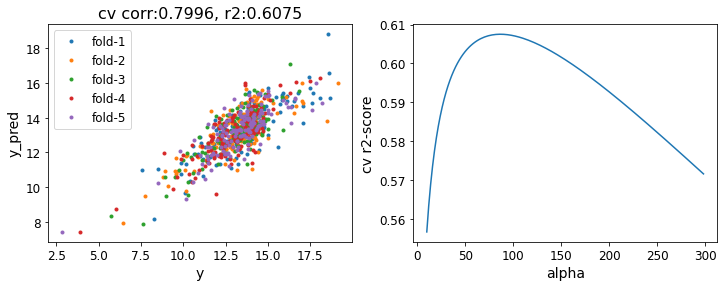

ok
=================      CTRP      =================
=========  Drug = ERLOTINIB, NGenes = 166  =========
Fitting 25 folds for each of 145 candidates, totalling 3625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.4s


----------------------
Ridge(alpha=118, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3625 out of 3625 | elapsed:    7.3s finished


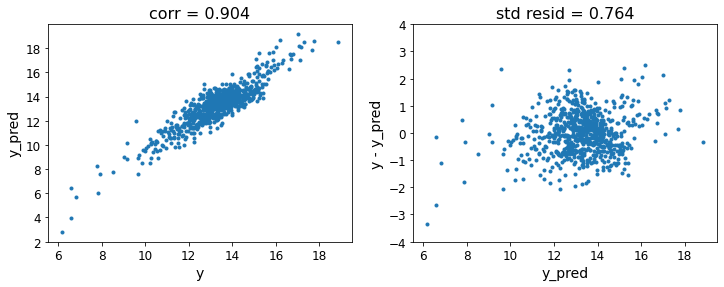

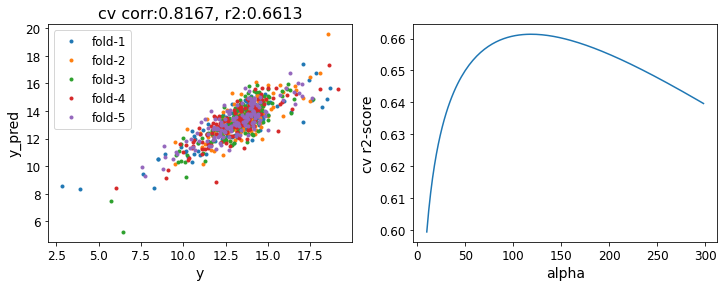

ok
=================      CTRP      =================
=========  Drug = ERLOTINIB, NGenes = 205  =========
Fitting 25 folds for each of 145 candidates, totalling 3625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    1.5s


----------------------
Ridge(alpha=154, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3625 out of 3625 | elapsed:    8.2s finished


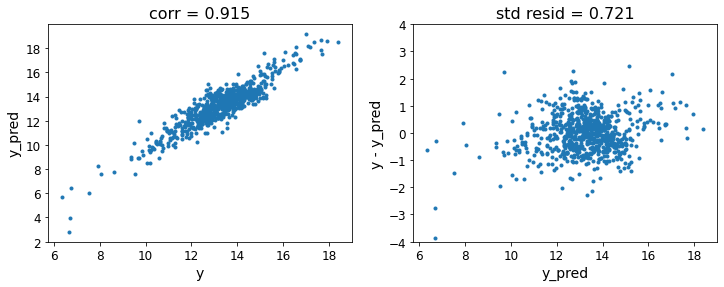

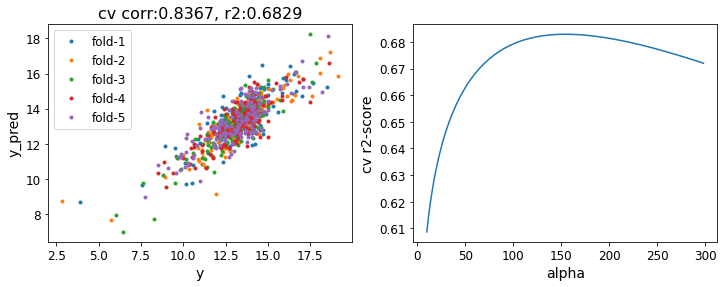

ok
=================      CTRP      =================
=========  Drug = ERLOTINIB, NGenes = 244  =========
Fitting 25 folds for each of 145 candidates, totalling 3625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.4s


----------------------
Ridge(alpha=200, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3625 out of 3625 | elapsed:    8.6s finished


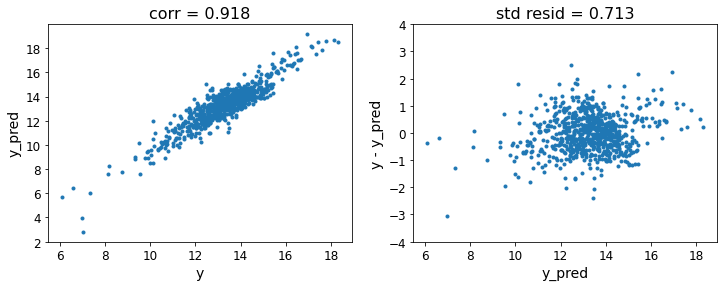

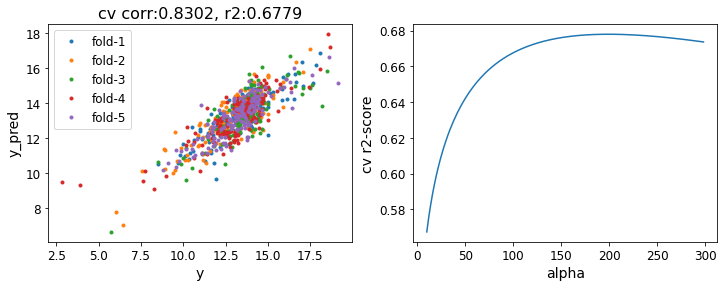

ok
=================      CTRP      =================
=========  Drug = ERLOTINIB, NGenes = 283  =========
Fitting 25 folds for each of 145 candidates, totalling 3625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 2380 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 3625 out of 3625 | elapsed:   10.1s finished


----------------------
Ridge(alpha=258, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


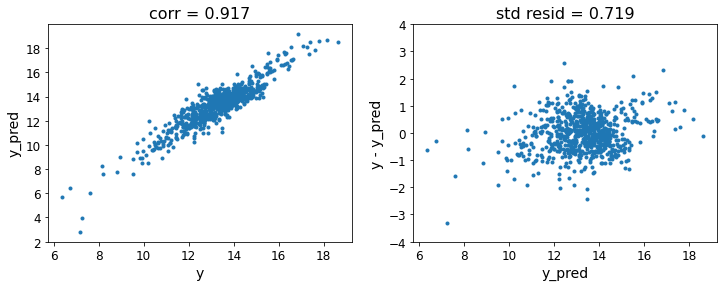

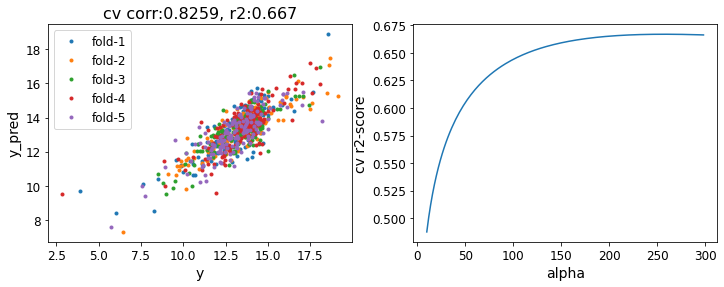

ok
=================      CTRP      =================
=========  Drug = ERLOTINIB, NGenes = 322  =========
Fitting 25 folds for each of 145 candidates, totalling 3625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 2380 tasks      | elapsed:    7.9s


----------------------
Ridge(alpha=298, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3625 out of 3625 | elapsed:   11.3s finished


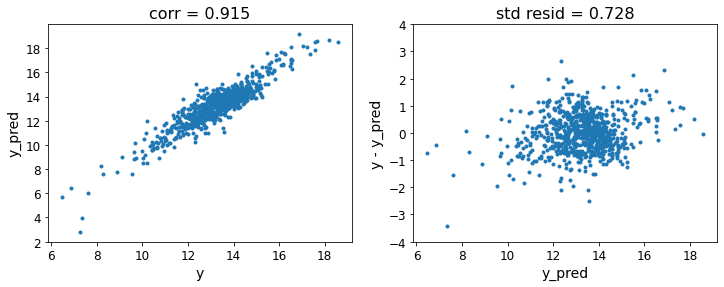

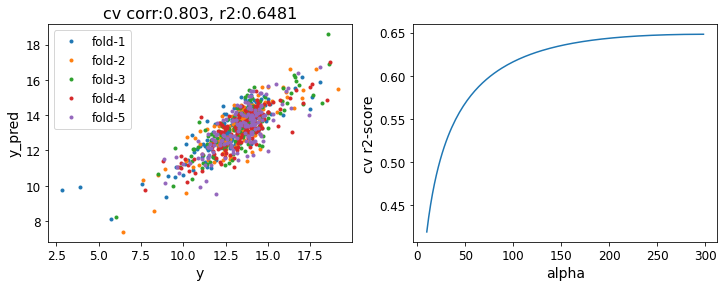

ok
=================      CTRP      =================
=========  Drug = ERLOTINIB, NGenes = 361  =========
Fitting 25 folds for each of 145 candidates, totalling 3625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 2380 tasks      | elapsed:    8.9s


----------------------
Ridge(alpha=298, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3625 out of 3625 | elapsed:   12.9s finished


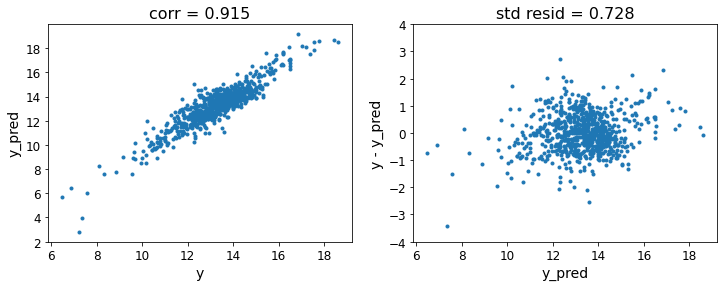

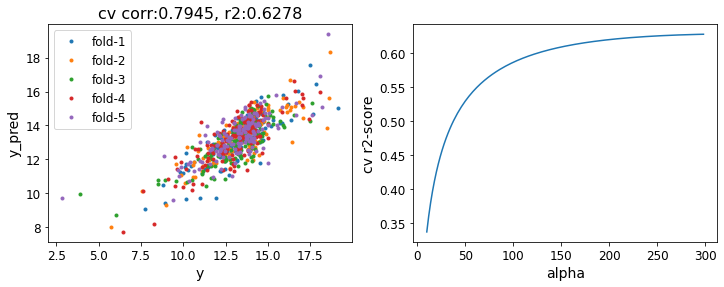

ok
=================      CTRP      =================
=========  Drug = ERLOTINIB, NGenes = 400  =========
Fitting 25 folds for each of 145 candidates, totalling 3625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 2440 tasks      | elapsed:   10.2s


----------------------
Ridge(alpha=298, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3625 out of 3625 | elapsed:   14.3s finished


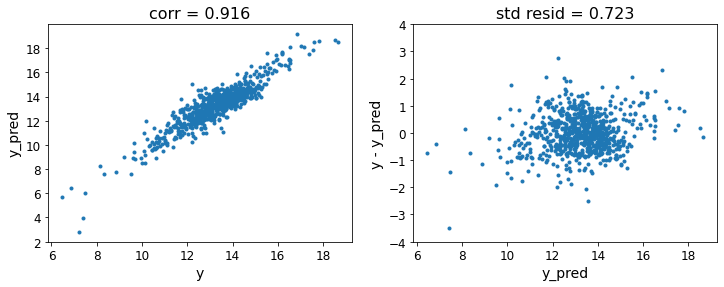

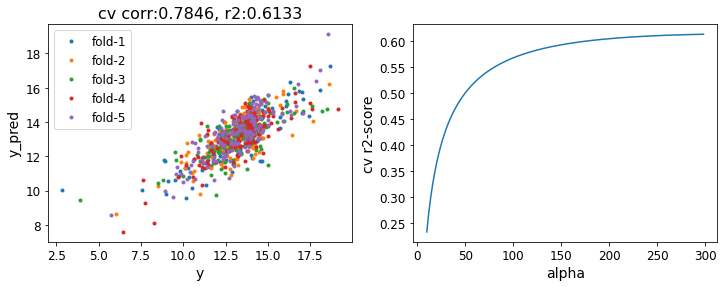

ok
=================      CTRP      =================
=========  Drug = ERLOTINIB, NGenes = 440  =========
Fitting 25 folds for each of 145 candidates, totalling 3625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 2380 tasks      | elapsed:   11.0s


----------------------
Ridge(alpha=298, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3625 out of 3625 | elapsed:   16.0s finished


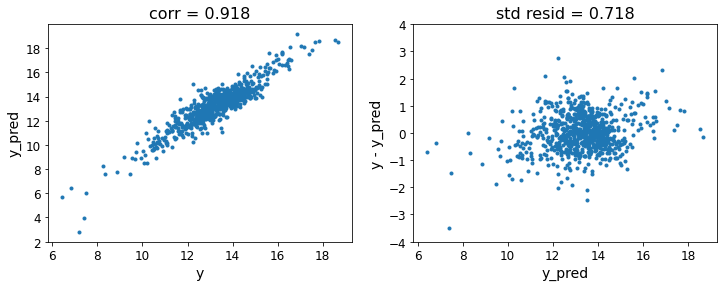

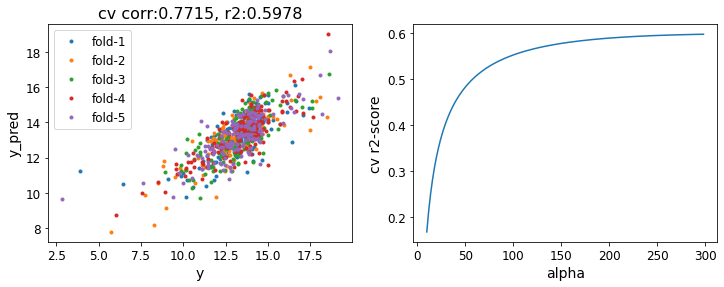

ok
=================      EBI      =================
=========  Drug = ERLOTINIB, NGenes = 10  =========
Fitting 25 folds for each of 145 candidates, totalling 3625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    1.3s


----------------------
Ridge(alpha=122, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3625 out of 3625 | elapsed:    4.5s finished


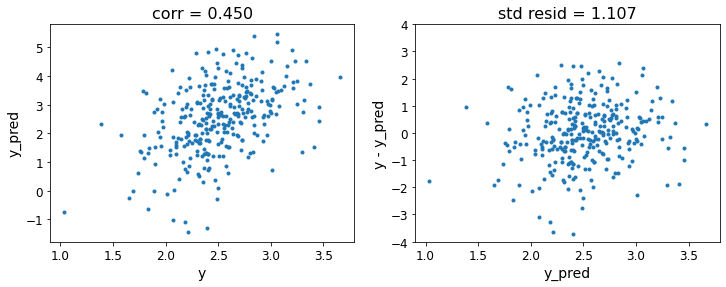

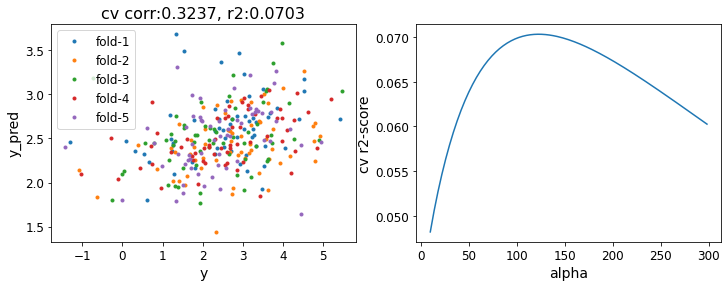

ok
=================      EBI      =================
=========  Drug = ERLOTINIB, NGenes = 45  =========
Fitting 25 folds for each of 145 candidates, totalling 3625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    1.3s


----------------------
Ridge(alpha=64, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3625 out of 3625 | elapsed:    4.6s finished


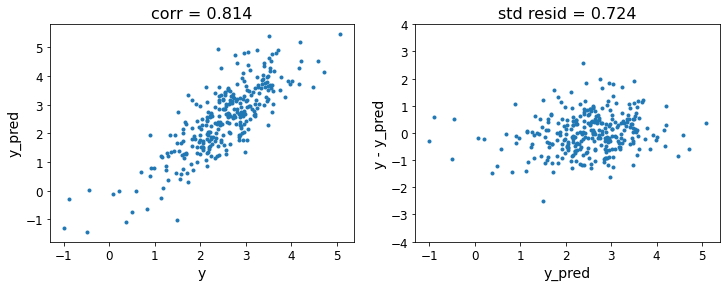

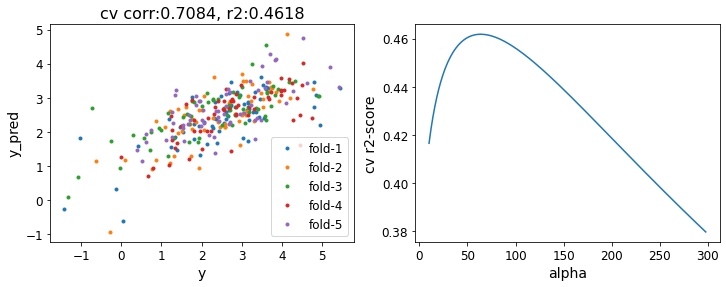

ok
=================      EBI      =================
=========  Drug = ERLOTINIB, NGenes = 80  =========
Fitting 25 folds for each of 145 candidates, totalling 3625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 3625 out of 3625 | elapsed:    4.7s finished


----------------------
Ridge(alpha=54, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


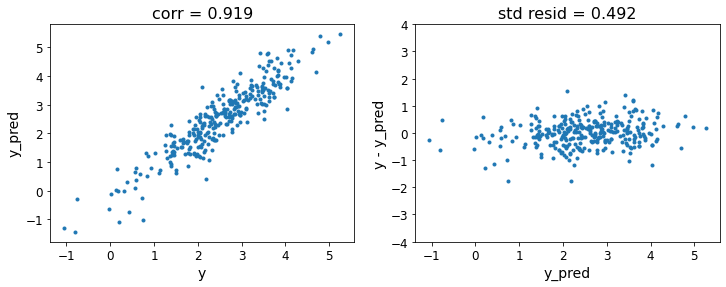

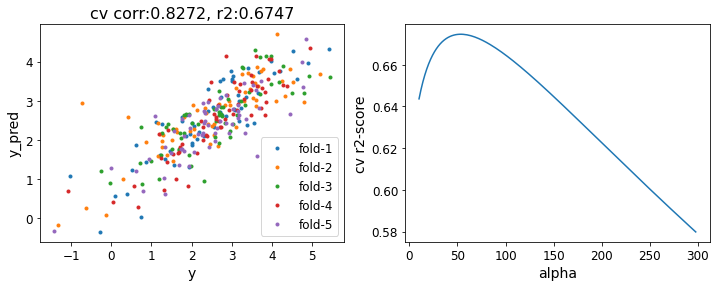

ok
=================      EBI      =================
=========  Drug = ERLOTINIB, NGenes = 116  =========
Fitting 25 folds for each of 145 candidates, totalling 3625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    1.3s


----------------------
Ridge(alpha=76, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3625 out of 3625 | elapsed:    5.0s finished


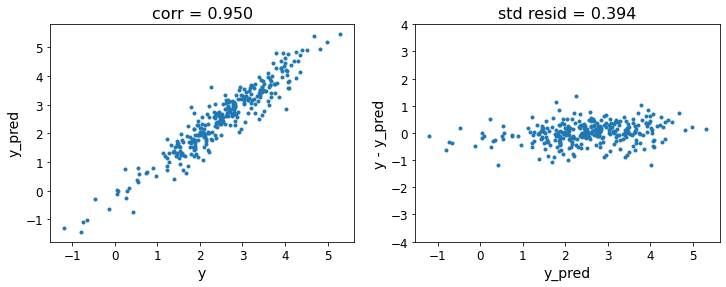

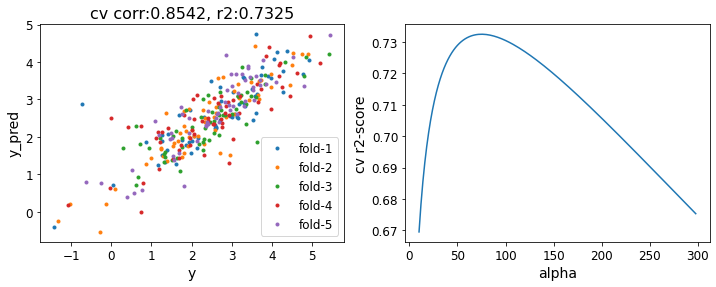

ok
=================      EBI      =================
=========  Drug = ERLOTINIB, NGenes = 151  =========
Fitting 25 folds for each of 145 candidates, totalling 3625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    1.4s


----------------------
Ridge(alpha=92, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3625 out of 3625 | elapsed:    5.3s finished


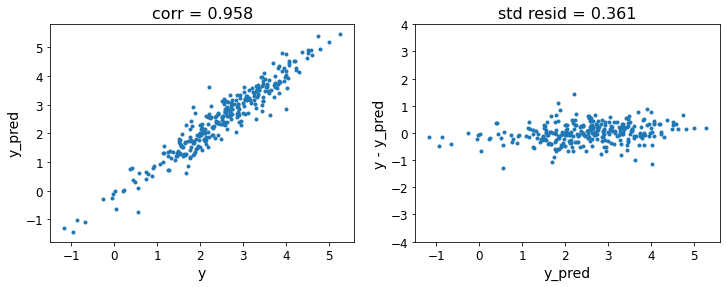

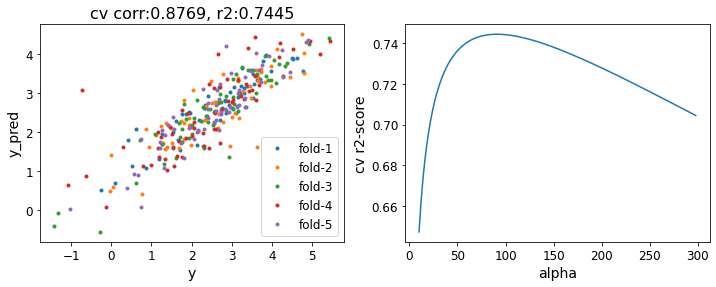

ok
=================      EBI      =================
=========  Drug = ERLOTINIB, NGenes = 187  =========
Fitting 25 folds for each of 145 candidates, totalling 3625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    1.5s


----------------------
Ridge(alpha=106, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3625 out of 3625 | elapsed:    5.8s finished


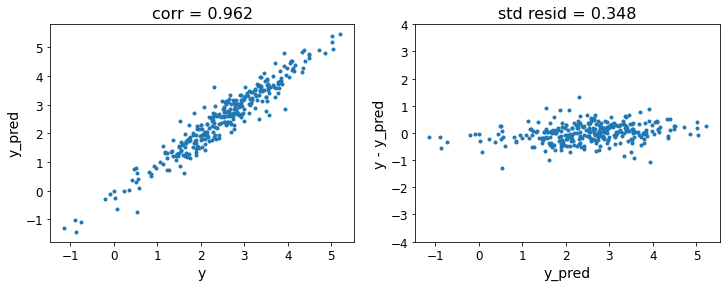

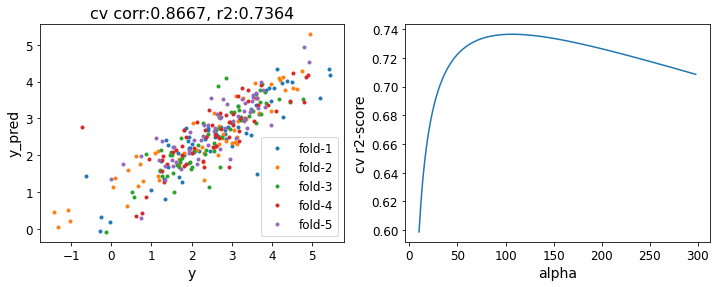

ok
=================      EBI      =================
=========  Drug = ERLOTINIB, NGenes = 222  =========
Fitting 25 folds for each of 145 candidates, totalling 3625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.3s


----------------------
Ridge(alpha=124, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3625 out of 3625 | elapsed:    6.4s finished


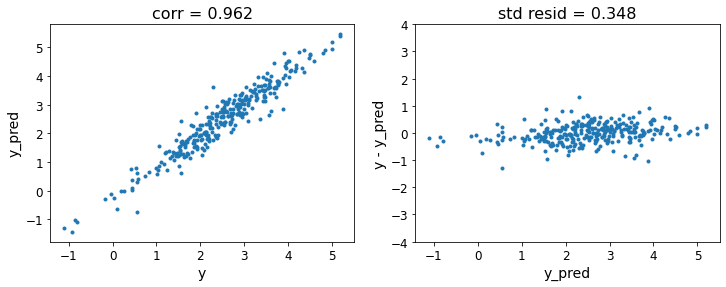

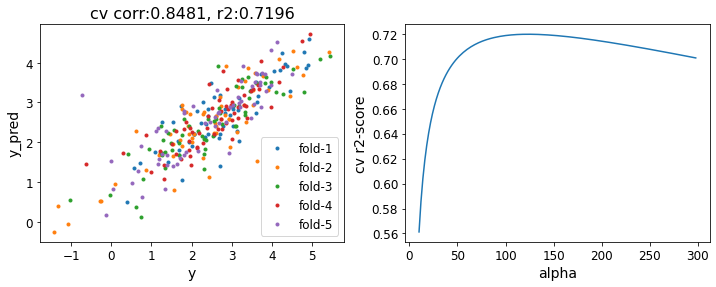

ok
=================      EBI      =================
=========  Drug = ERLOTINIB, NGenes = 258  =========
Fitting 25 folds for each of 145 candidates, totalling 3625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.5s


----------------------
Ridge(alpha=148, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3625 out of 3625 | elapsed:    6.9s finished


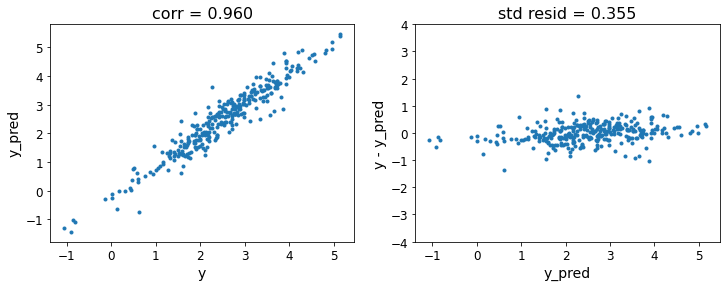

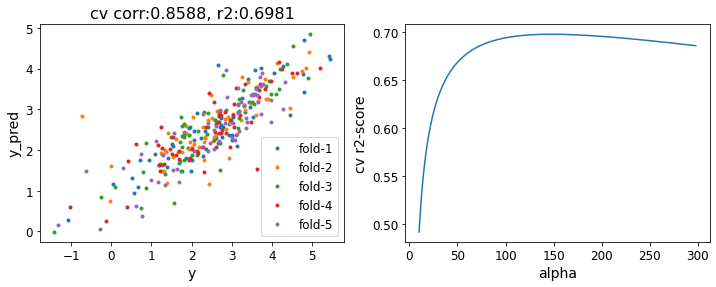

ok
=================      EBI      =================
=========  Drug = ERLOTINIB, NGenes = 293  =========
Fitting 25 folds for each of 145 candidates, totalling 3625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.4s


----------------------
Ridge(alpha=144, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3625 out of 3625 | elapsed:    7.2s finished


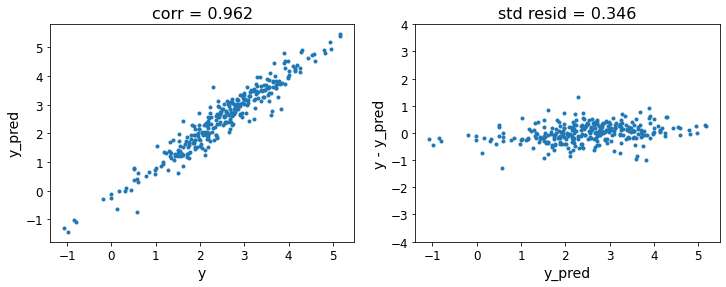

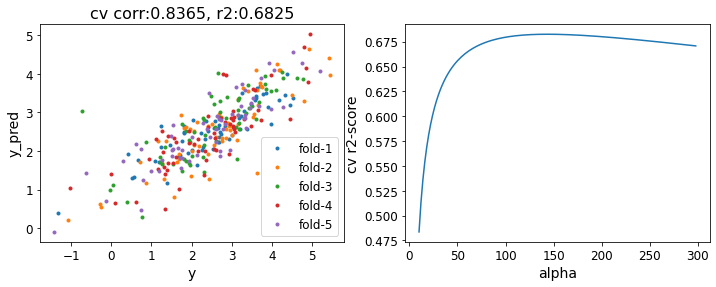

ok
=================      EBI      =================
=========  Drug = ERLOTINIB, NGenes = 329  =========
Fitting 25 folds for each of 145 candidates, totalling 3625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.4s


----------------------
Ridge(alpha=152, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3625 out of 3625 | elapsed:    7.5s finished


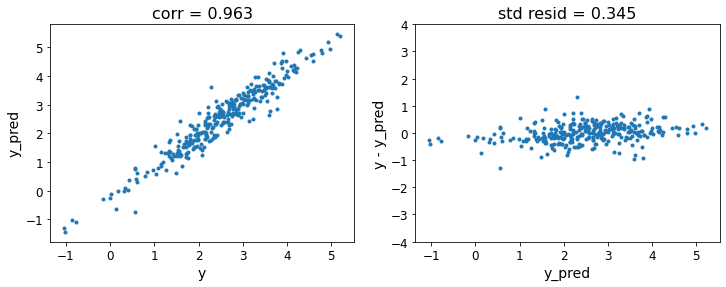

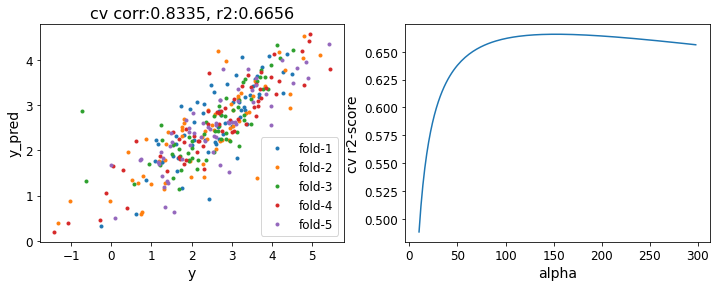

ok
=================      EBI      =================
=========  Drug = ERLOTINIB, NGenes = 364  =========
Fitting 25 folds for each of 145 candidates, totalling 3625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    1.5s


----------------------
Ridge(alpha=166, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3625 out of 3625 | elapsed:    7.8s finished


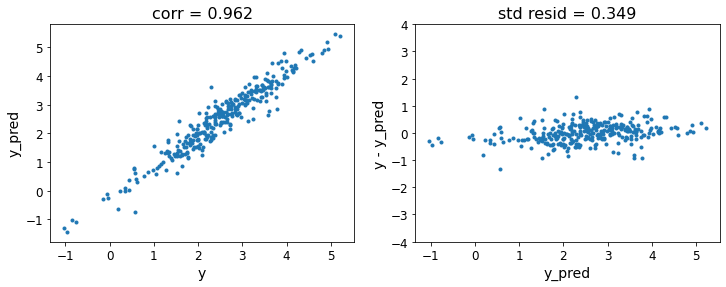

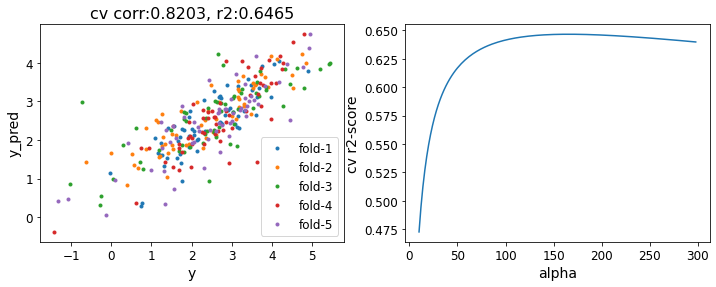

ok
=================      EBI      =================
=========  Drug = ERLOTINIB, NGenes = 400  =========
Fitting 25 folds for each of 145 candidates, totalling 3625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.4s


----------------------
Ridge(alpha=188, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3625 out of 3625 | elapsed:    8.0s finished


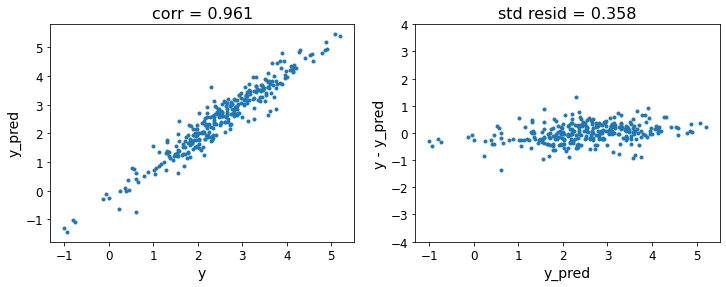

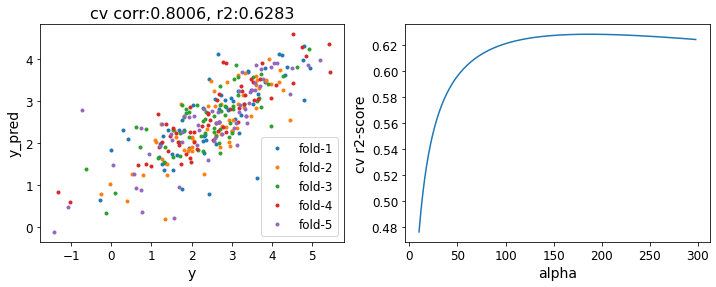

ok


In [17]:
splits = 5
repeats = 5


for drug in drug_list:
    
    mask1 = ~df_ctrp.loc[:,drug].isna()
    ctrp_x =  df_ctrp[mask1].iloc[:,:Ngenes]
    out = scaler.fit_transform(ctrp_x)
    ctrp_x = pd.DataFrame(out, columns=ctrp_x.columns, index=list(ctrp_x.index.values))
    ctrp_y = df_ctrp[mask1].loc[:,drug]
    m1 = ~cv_res_df[drug+'-ctrp'].isna()
    ctrp_sgenes = list(cv_res_df[m1][drug+'-ctrp'])
    ctrp_loop = np.linspace(10,len(ctrp_sgenes),12, dtype=int)

    mask2 = ~df_ebi.loc[:,drug].isna()
    ebi_x =  df_ebi[mask2].iloc[:,:Ngenes]
    out = scaler.fit_transform(ebi_x)
    ebi_x = pd.DataFrame(out, columns=ebi_x.columns, index=list(ebi_x.index.values))
    ebi_y = df_ebi[mask2].loc[:,drug]
    m2 = ~cv_res_df[drug+'-ebi'].isna()
    ebi_sgenes = list(cv_res_df[m2][drug+'-ebi'])
    ebi_loop = np.linspace(10,len(ebi_sgenes),12, dtype=int)
                     
    model = Ridge(max_iter=10000)
    alph_range = np.arange(10,300,2)
    param_grid = {'alpha': alph_range}

    for Sel_NGene in ctrp_loop:
        Genes = ctrp_sgenes[:Sel_NGene]
        print("=================      CTRP      =================")
        print('=========  Drug = {}, NGenes = {}  ========='.format(drug, Sel_NGene))
        x = ctrp_x.loc[:,Genes]
        y = ctrp_y
        best_model,cv_score,grid_results = train_model(model, param_grid=param_grid, splits=splits, repeats=repeats, X=x, y=y)
        cv_r2 = cv_score['mean']
        cv_r2 = np.around(cv_r2,4)
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        #y_pred = get_cross_val_pred(best_model,X=x, y=y)
        y_pred_list, y_true_list, y_pred, y = get_cross_val_prediction(best_model,X=x,y=y)
        corr = np.corrcoef(x=y_pred, y=y)
        corr = np.around(corr[0,1],4)
        plt.plot(y_true_list[0],y_pred_list[0],'.',label='fold-1')
        plt.plot(y_true_list[1],y_pred_list[1],'.',label='fold-2')
        plt.plot(y_true_list[2],y_pred_list[2],'.',label='fold-3')
        plt.plot(y_true_list[3],y_pred_list[3],'.',label='fold-4')
        plt.plot(y_true_list[4],y_pred_list[4],'.',label='fold-5')
        plt.legend()
        plt.xlabel('y')
        plt.ylabel('y_pred')
        plt.title('cv corr:{}, r2:{}'.format(corr,cv_r2))
        plt.subplot(1,2,2)
        plt.plot(alph_range, abs(grid_results['mean_test_score']))
        plt.xlabel('alpha')
        plt.ylabel('cv r2-score')
        plt.show()
        cv_r2_df.loc[Sel_NGene,drug+'-ctrp'] = cv_r2
        
        f_name = 'S-CCLE-{}-{}.csv'.format(drug,Sel_NGene)
        df = pd.DataFrame(columns=['y_hat','y'])
        df['y_hat'] = y_pred
        df['y'] = y
        df.to_csv(f_name)
        print('ok')

    for Sel_NGene in ebi_loop:
        Genes = ebi_sgenes[:Sel_NGene]
        print("=================      EBI      =================")
        print('=========  Drug = {}, NGenes = {}  ========='.format(drug, Sel_NGene))
        x = ebi_x.loc[:,Genes]
        y = ebi_y
        best_model,cv_score,grid_results = train_model(model, param_grid=param_grid, splits=splits, repeats=repeats, X=x, y=y)
        cv_r2 = cv_score['mean']
        cv_r2 = np.around(cv_r2,4)
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        y_pred_list, y_true_list, y_pred, y = get_cross_val_prediction(best_model,X=x,y=y)
        corr = np.corrcoef(x=y_pred, y=y)
        corr = np.around(corr[0,1],4)
        plt.plot(y_true_list[0],y_pred_list[0],'.',label='fold-1')
        plt.plot(y_true_list[1],y_pred_list[1],'.',label='fold-2')
        plt.plot(y_true_list[2],y_pred_list[2],'.',label='fold-3')
        plt.plot(y_true_list[3],y_pred_list[3],'.',label='fold-4')
        plt.plot(y_true_list[4],y_pred_list[4],'.',label='fold-5')
        plt.legend()
        plt.xlabel('y')
        plt.ylabel('y_pred')
        plt.title('cv corr:{}, r2:{}'.format(corr,cv_r2))
        plt.subplot(1,2,2)
        plt.plot(alph_range, abs(grid_results['mean_test_score']))
        plt.xlabel('alpha')
        plt.ylabel('cv r2-score')
        plt.show()
        cv_r2_df.loc[Sel_NGene,drug+'-ebi'] = cv_r2
        
        f_name = 'S-GDSC-{}-{}.csv'.format(drug,Sel_NGene)
        df = pd.DataFrame(columns=['y_hat','y'])
        df['y_hat'] = y_pred
        df['y'] = y
        df.to_csv(f_name)
        print('ok')




In [18]:
f = 'cv_r2_eachdata_tdrug_new.csv'
cv_r2_df.to_csv(f)

In [19]:
f = 'cv_r2_eachdata_tdrug_new.csv'
cv_r2_df = pd.read_csv(f,index_col=0)

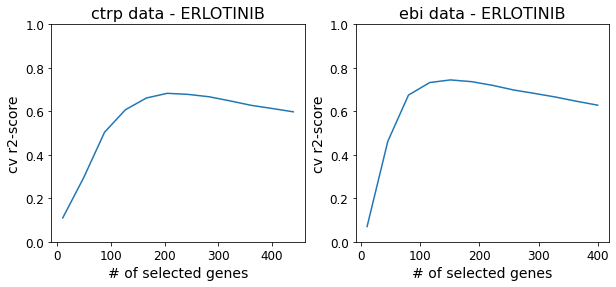

In [20]:
#

for drug in drug_list:
    
    
    m1 = ~cv_r2_df[drug+'-ctrp'].isna()
    N_used_genes = list(cv_r2_df[m1][drug+'-ctrp'].index)
    ctrp_res = list(cv_r2_df[m1][drug+'-ctrp'])
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(N_used_genes, ctrp_res)
    plt.ylim((0,1))
    plt.xlabel('# of selected genes')
    plt.ylabel('cv r2-score')
    plt.title('ctrp data - {}'.format(drug))
    plt.subplot(1,2,2)
    
    m2 = ~cv_r2_df[drug+'-ebi'].isna()
    N_used_genes = list(cv_r2_df[m2][drug+'-ebi'].index)
    ebi_res = list(cv_r2_df[m2][drug+'-ebi'])
   
    plt.plot(N_used_genes, ebi_res)
    plt.ylim((0,1))
    plt.xlabel('# of selected genes')
    plt.ylabel('cv r2-score')
    plt.title('ebi data - {}'.format(drug))

    
    

# ElasticNet(s+i) - Feature Selection

In [21]:
f="Bootstrap_Genes_ctrp_tdrug_new.csv"
ctrp_genes_df = pd.read_csv(f, index_col=0)
f="Bootstrap_Genes_ebi_tdrug_new.csv"
ebi_genes_df = pd.read_csv(f, index_col=0)

In [22]:
sorted_genes_cols = []
for drug in drug_list:
    sorted_genes_cols.append(drug+'-ctrp')
    sorted_genes_cols.append(drug+'-ebi')
df_sorted_genes = pd.DataFrame(columns=sorted_genes_cols, index=range(1500))

In [23]:
poly = PolynomialFeatures(interaction_only=True)

def get_poly_importance(df):
    candidates = []
    features = list(df.columns)
    for f in features:
        f_parse = f.split(' ')
        if len(f_parse) > 1:
            candidates.append(f_parse[0])
            candidates.append(f_parse[1])
        else:
            candidates.append(f_parse[0])
    importance_df = pd.DataFrame.from_dict(dict(Counter(candidates)), orient='index', columns=['importance'])
    df_ = importance_df['importance'].sort_values(ascending=False)
    return df_

    

In [24]:
df_sorted_genes

ERLOTINIB-ctrp ERLOTINIB-ebi
0               NaN           NaN
1               NaN           NaN
2               NaN           NaN
3               NaN           NaN
4               NaN           NaN
...             ...           ...
1495            NaN           NaN
1496            NaN           NaN
1497            NaN           NaN
1498            NaN           NaN
1499            NaN           NaN

[1500 rows x 2 columns]

# define N_features ( # of Maximum input features ) 

drug = ERLOTINIB
ctrp original features length = 500
with interactions => 125250
Fitting 10 folds for each of 29 candidates, totalling 290 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  5.0min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  9.3min
[Parallel(n_jobs=4)]: Done 290 out of 290 | elapsed: 10.9min finished


----------------------
Lasso(alpha=0.009000000000000001, copy_X=True, fit_intercept=True,
      max_iter=10000, normalize=False, positive=False, precompute=False,
      random_state=777, selection='cyclic', tol=0.0001, warm_start=False)
----------------------


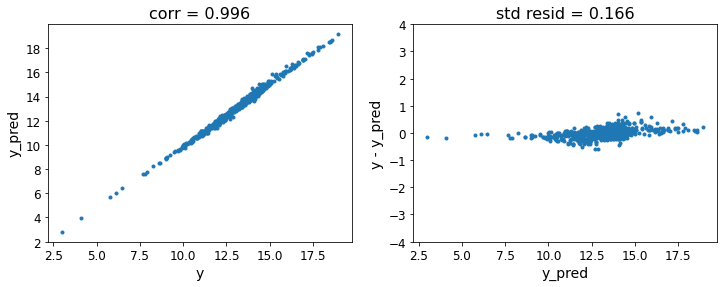

645 non-zero coefficients
ebi original features length = 500
with interactions => 125250
Fitting 10 folds for each of 29 candidates, totalling 290 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.5min
[Parallel(n_jobs=4)]: Done 290 out of 290 | elapsed:  5.4min finished


----------------------
Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=777,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------


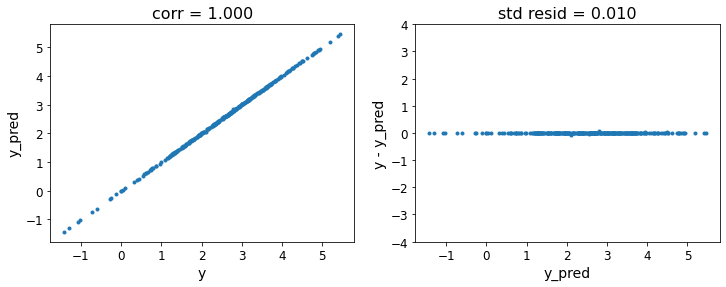

335 non-zero coefficients


In [25]:
N_features = 20000
random_state = 777
splits = 10
repeats = 1

# model = ElasticNet(max_iter=1000, random_state = random_state)
# alph_range = np.arange(0.1,1,0.1)
# param_grid = {'alpha': alph_range,
#               'l1_ratio': np.arange(0.01,0.1,0.01),
#               }

model = Lasso(max_iter=10000, random_state = random_state)
alph_range = np.arange(0.001,0.03,0.001)
param_grid = {'alpha': alph_range,
              }

for drug in drug_list:
    print("drug = {}".format(drug))   
    mask1 = ~df_ctrp.loc[:,drug].isna()
    ctrp_x =  df_ctrp[mask1].iloc[:,:Ngenes]
    out = scaler.fit_transform(ctrp_x)
    ctrp_x = pd.DataFrame(out, columns=ctrp_x.columns, index=list(ctrp_x.index.values))
    ctrp_y = df_ctrp[mask1].loc[:,drug]

    ctrp_sgenes = list(ctrp_genes_df[drug])
    print("ctrp original features length = {}".format(len(ctrp_sgenes)))
    ctrp_x = ctrp_x.loc[:,ctrp_sgenes]
    ctrp_poly_values = poly.fit_transform(ctrp_x)
    ctrp_poly_columns =poly.get_feature_names(ctrp_sgenes)
    print("with interactions => {}".format(len(ctrp_poly_columns)-1))
    ctrp_poly = pd.DataFrame(ctrp_poly_values[:,1:],columns=ctrp_poly_columns[1:] ,index=ctrp_x.index)
    ctrp_single_term = ctrp_poly.iloc[:,:len(ctrp_sgenes)]
    ctrp_cross_term = ctrp_poly.iloc[:,len(ctrp_sgenes):]
    scaling_values = scaler.fit_transform(ctrp_cross_term)
    ctrp_cross_term = pd.DataFrame(scaling_values, columns=ctrp_cross_term.columns, index=list(ctrp_cross_term.index.values))
    ctrp_poly = pd.merge(ctrp_single_term, ctrp_cross_term, left_index=True, right_index=True, how='left')
    corrwith_drug = ctrp_poly.corrwith(ctrp_y)
    features = list(corrwith_drug.abs().sort_values(ascending=False)[:N_features].index)
    ctrp_poly = ctrp_poly.loc[:,features]
    importance_poly = get_poly_importance(ctrp_poly)
    f_name = drug+'-ctrp-poly-importance.csv'
    importance_poly.to_csv(f_name)

    ctrp_model,cv_score,grid_results = train_model(model, param_grid=param_grid, 
                                                  splits=splits, repeats=repeats, X=ctrp_poly, y=ctrp_y)

    en_coefs = pd.Series(ctrp_model.coef_,index=ctrp_poly.columns)
    print(sum(en_coefs!=0),'non-zero coefficients')
    ctrp_sorted_poly = list(en_coefs[en_coefs!=0].abs().sort_values(ascending=False).index)
    if len(ctrp_sorted_poly) < 1500:
        ctrp_sorted_poly = ctrp_sorted_poly + [np.nan]*(1500-len(ctrp_sorted_poly))
    else:
        ctrp_sorted_poly = ctrp_sorted_poly[:1500]    
    df_sorted_genes.loc[:,drug+'-ctrp'] = ctrp_sorted_poly
    
    
    mask2 = ~df_ebi.loc[:,drug].isna()
    ebi_x =  df_ebi[mask2].iloc[:,:Ngenes]
    out = scaler.fit_transform(ebi_x)
    ebi_x = pd.DataFrame(out, columns=ebi_x.columns, index=list(ebi_x.index.values))
    ebi_y = df_ebi[mask2].loc[:,drug]

    ebi_sgenes = list(ebi_genes_df[drug])
    print("ebi original features length = {}".format(len(ebi_sgenes)))
    ebi_x = ebi_x.loc[:,ebi_sgenes]
    ebi_poly_values = poly.fit_transform(ebi_x)
    ebi_poly_columns =poly.get_feature_names(ebi_sgenes)
    print("with interactions => {}".format(len(ebi_poly_columns)-1))
    ebi_poly = pd.DataFrame(ebi_poly_values[:,1:],columns=ebi_poly_columns[1:] ,index=ebi_x.index)
    ebi_single_term = ebi_poly.iloc[:,:len(ebi_sgenes)]
    ebi_cross_term = ebi_poly.iloc[:,len(ebi_sgenes):]
    scaling_values = scaler.fit_transform(ebi_cross_term)
    ebi_cross_term = pd.DataFrame(scaling_values, columns=ebi_cross_term.columns, index=list(ebi_cross_term.index.values))
    ebi_poly = pd.merge(ebi_single_term, ebi_cross_term, left_index=True, right_index=True, how='left')
    corrwith_drug = ebi_poly.corrwith(ebi_y)
    features = list(corrwith_drug.abs().sort_values(ascending=False)[:N_features].index)
    ebi_poly = ebi_poly.loc[:,features]
    importance_poly = get_poly_importance(ebi_poly)
    f_name = drug+'-ebi-poly-importance.csv'
    importance_poly.to_csv(f_name)

    ebi_model,cv_score,grid_results = train_model(model, param_grid=param_grid, 
                                                  splits=splits, repeats=repeats, X=ebi_poly, y=ebi_y)

    en_coefs = pd.Series(ebi_model.coef_,index=ebi_poly.columns)
    print(sum(en_coefs!=0),'non-zero coefficients')
    ebi_sorted_poly = list(en_coefs[en_coefs!=0].abs().sort_values(ascending=False).index)
    if len(ebi_sorted_poly) < 1500:
        ebi_sorted_poly = ebi_sorted_poly + [np.nan]*(1500-len(ebi_sorted_poly))
    else:
        ebi_sorted_poly = ebi_sorted_poly[:1500]    
    df_sorted_genes.loc[:,drug+'-ebi'] = ebi_sorted_poly
    
    







In [26]:
df_sorted_genes

ERLOTINIB-ctrp   ERLOTINIB-ebi
0             MYBPH  NR2F1 PPP1R14C
1       MUC22 FANCF     MT1HL1 STRN
2        ACOX3 PPBP     WDR18 OR1J1
3      CAMK2B PYDC2   ELOVL3 FRMPD4
4        DRD1 TTLL8       XDH PSMD5
...             ...             ...
1495            NaN             NaN
1496            NaN             NaN
1497            NaN             NaN
1498            NaN             NaN
1499            NaN             NaN

[1500 rows x 2 columns]

In [27]:
f = 'each_poly_genes_sorted_tdrug_lasso.csv'
df_sorted_genes.to_csv(f)


In [28]:
f = 'each_poly_genes_sorted_tdrug_lasso.csv'
df_sorted_genes = pd.read_csv(f, index_col=0)
f="Bootstrap_Genes_ctrp_tdrug_new.csv"
ctrp_genes_df = pd.read_csv(f, index_col=0)
f="Bootstrap_Genes_ebi_tdrug_new.csv"
ebi_genes_df = pd.read_csv(f, index_col=0)

In [29]:
index_ = list(np.arange(10,1501,1))
res_df_cols = []
for drug in drug_list:
    res_df_cols.append(drug+'-'+'ctrp')
    res_df_cols.append(drug+'-'+'ebi')
cv_r2_df = pd.DataFrame(columns=res_df_cols, index=index_)
cv_r2_df

ERLOTINIB-ctrp ERLOTINIB-ebi
10              NaN           NaN
11              NaN           NaN
12              NaN           NaN
13              NaN           NaN
14              NaN           NaN
...             ...           ...
1496            NaN           NaN
1497            NaN           NaN
1498            NaN           NaN
1499            NaN           NaN
1500            NaN           NaN

[1491 rows x 2 columns]

# cross val R2 score ElasticNet(s+i)

current step 1 / total 1
ctrp original features length = 500
with interactions => 125250
ebi original features length = 500
with interactions => 125250
CTRP -  Drug: ERLOTINIB, N_genes: 10
Fitting 25 folds for each of 150 candidates, totalling 3750 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    1.4s


----------------------
Ridge(alpha=225, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3750 out of 3750 | elapsed:    4.9s finished


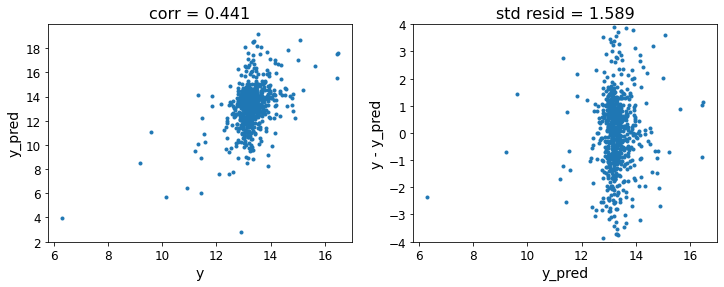

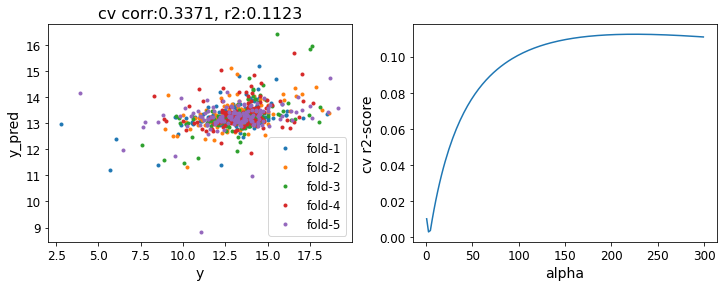

CTRP -  Drug: ERLOTINIB, N_genes: 67
Fitting 25 folds for each of 150 candidates, totalling 3750 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    1.4s


----------------------
Ridge(alpha=55, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3750 out of 3750 | elapsed:    5.2s finished


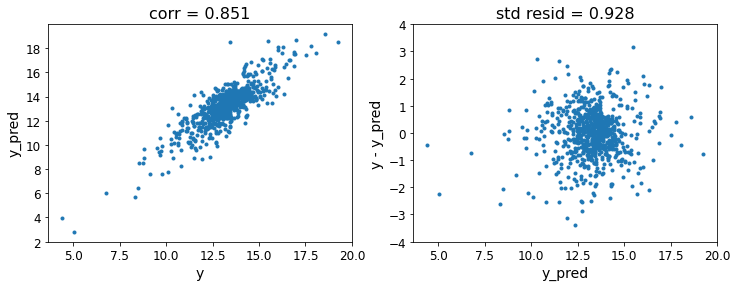

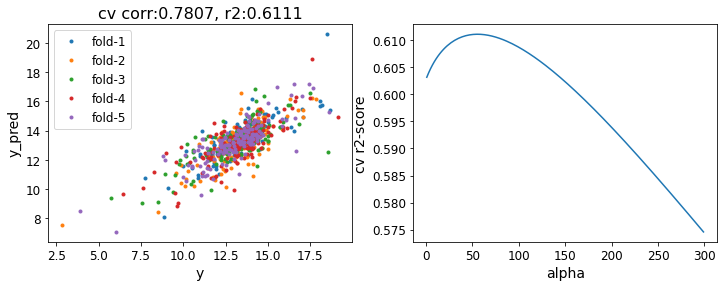

CTRP -  Drug: ERLOTINIB, N_genes: 125
Fitting 25 folds for each of 150 candidates, totalling 3750 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.6s


----------------------
Ridge(alpha=65, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3750 out of 3750 | elapsed:    6.3s finished


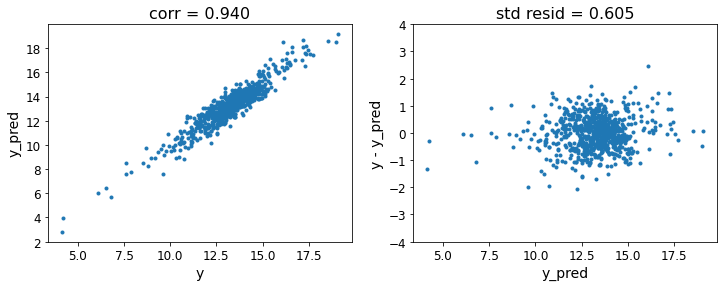

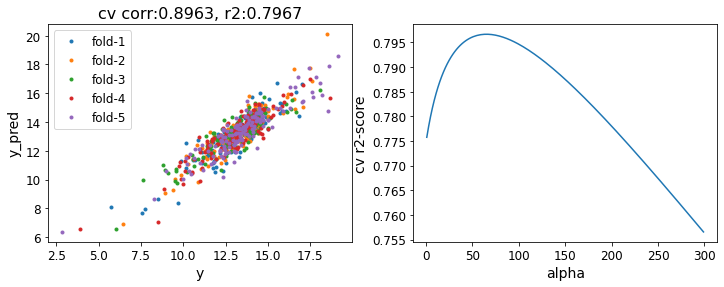

CTRP -  Drug: ERLOTINIB, N_genes: 183
Fitting 25 folds for each of 150 candidates, totalling 3750 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.4s


----------------------
Ridge(alpha=55, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3750 out of 3750 | elapsed:    7.8s finished


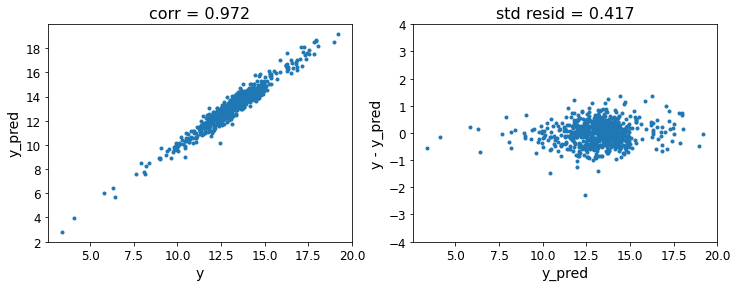

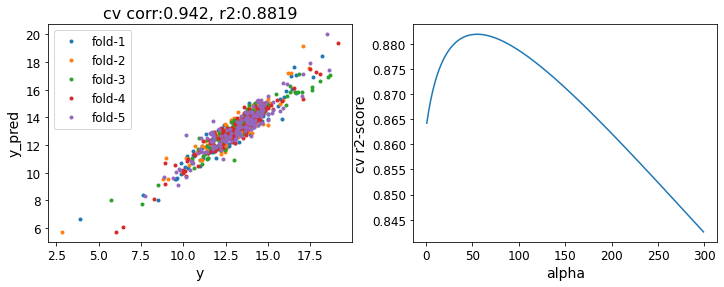

CTRP -  Drug: ERLOTINIB, N_genes: 240
Fitting 25 folds for each of 150 candidates, totalling 3750 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.4s


----------------------
Ridge(alpha=49, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3750 out of 3750 | elapsed:    9.0s finished


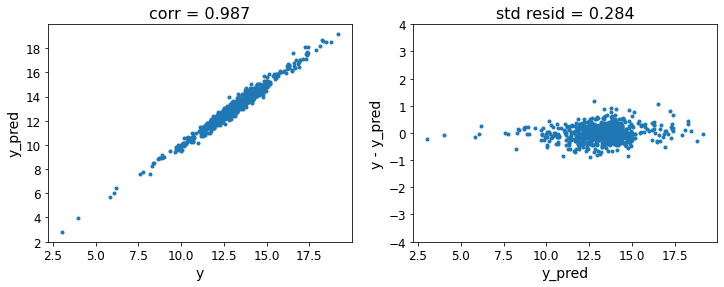

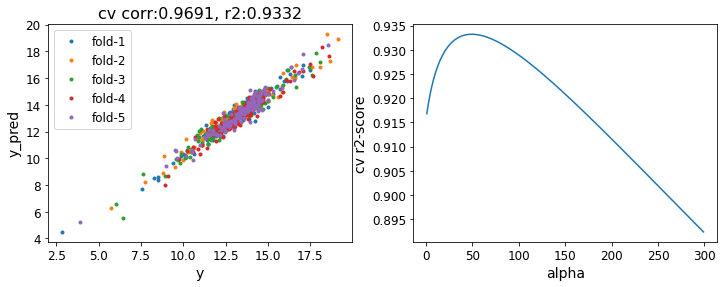

CTRP -  Drug: ERLOTINIB, N_genes: 298
Fitting 25 folds for each of 150 candidates, totalling 3750 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 2380 tasks      | elapsed:    7.4s


----------------------
Ridge(alpha=49, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3750 out of 3750 | elapsed:   10.8s finished


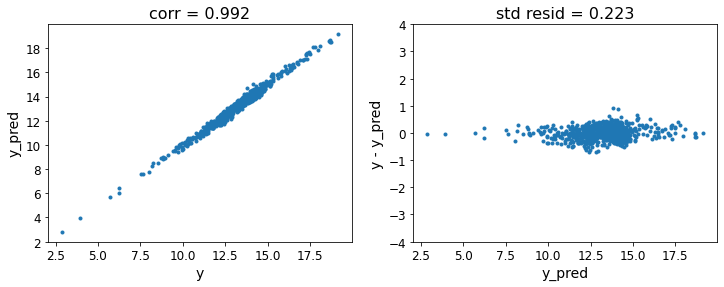

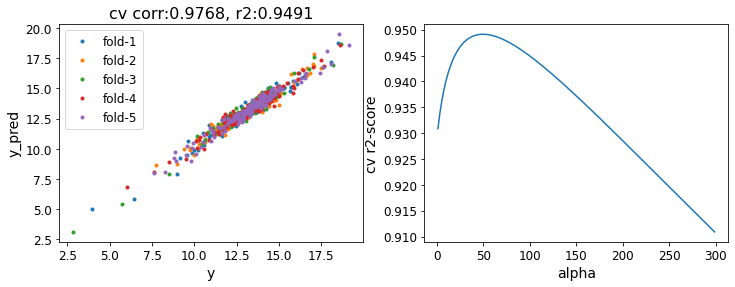

CTRP -  Drug: ERLOTINIB, N_genes: 356
Fitting 25 folds for each of 150 candidates, totalling 3750 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 2380 tasks      | elapsed:    8.8s


----------------------
Ridge(alpha=47, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3750 out of 3750 | elapsed:   12.9s finished


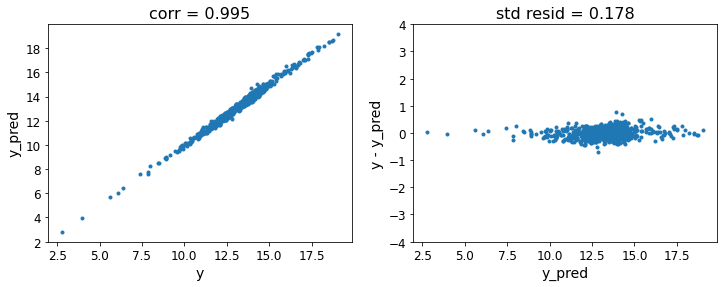

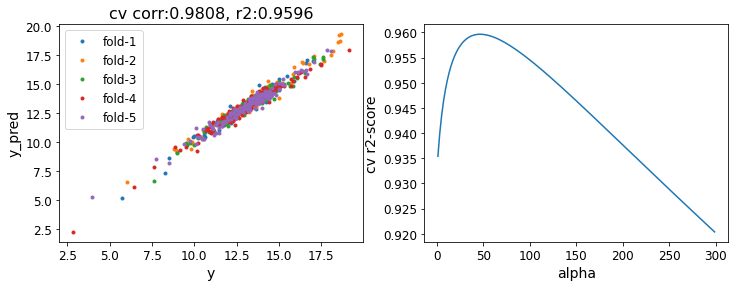

CTRP -  Drug: ERLOTINIB, N_genes: 414
Fitting 25 folds for each of 150 candidates, totalling 3750 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 2380 tasks      | elapsed:   10.2s


----------------------
Ridge(alpha=41, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3750 out of 3750 | elapsed:   15.2s finished


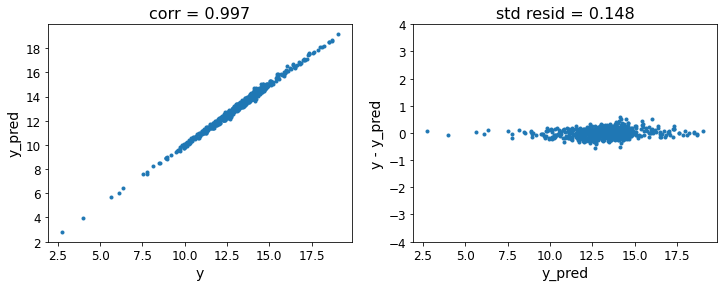

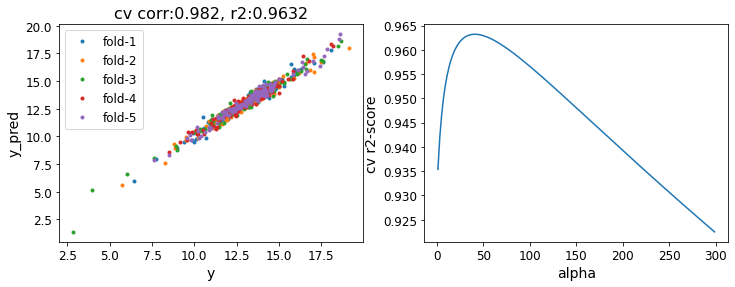

CTRP -  Drug: ERLOTINIB, N_genes: 471
Fitting 25 folds for each of 150 candidates, totalling 3750 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 1260 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done 3260 tasks      | elapsed:   16.3s


----------------------
Ridge(alpha=37, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3750 out of 3750 | elapsed:   18.5s finished


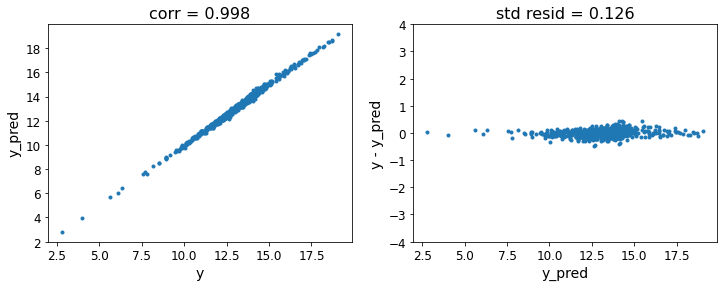

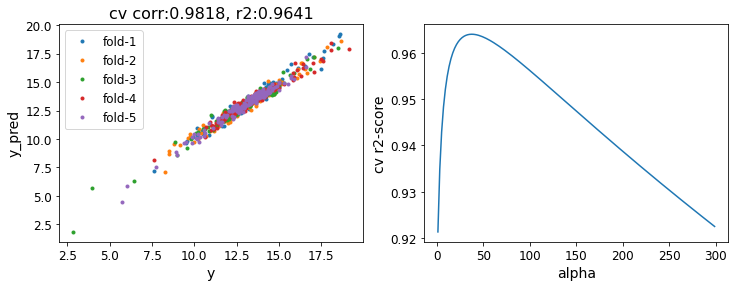

CTRP -  Drug: ERLOTINIB, N_genes: 529
Fitting 25 folds for each of 150 candidates, totalling 3750 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 1260 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 3260 tasks      | elapsed:   18.7s


----------------------
Ridge(alpha=35, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3750 out of 3750 | elapsed:   21.4s finished


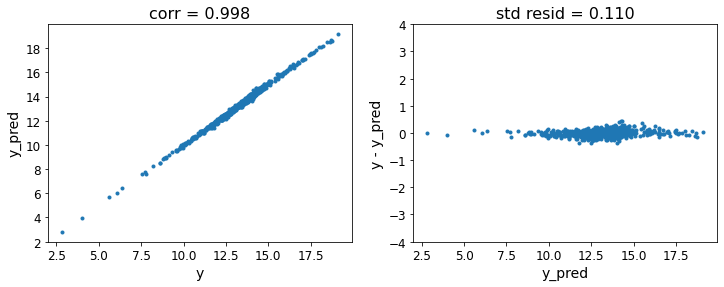

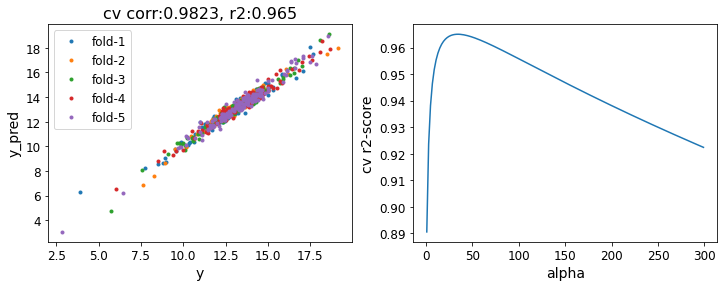

CTRP -  Drug: ERLOTINIB, N_genes: 587
Fitting 25 folds for each of 150 candidates, totalling 3750 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 1260 tasks      | elapsed:    9.2s
[Parallel(n_jobs=4)]: Done 3260 tasks      | elapsed:   21.8s


----------------------
Ridge(alpha=37, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3750 out of 3750 | elapsed:   24.9s finished


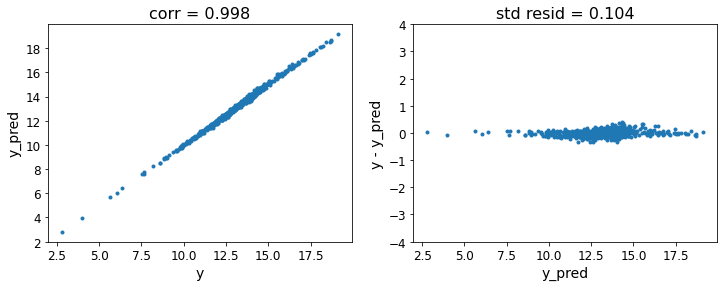

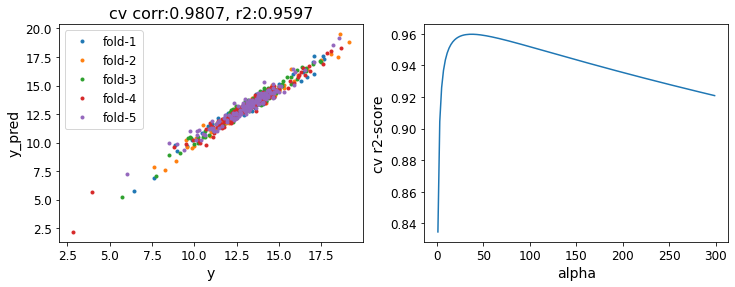

CTRP -  Drug: ERLOTINIB, N_genes: 645
Fitting 25 folds for each of 150 candidates, totalling 3750 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 1260 tasks      | elapsed:    9.6s
[Parallel(n_jobs=4)]: Done 3260 tasks      | elapsed:   22.8s


----------------------
Ridge(alpha=39, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3750 out of 3750 | elapsed:   26.2s finished


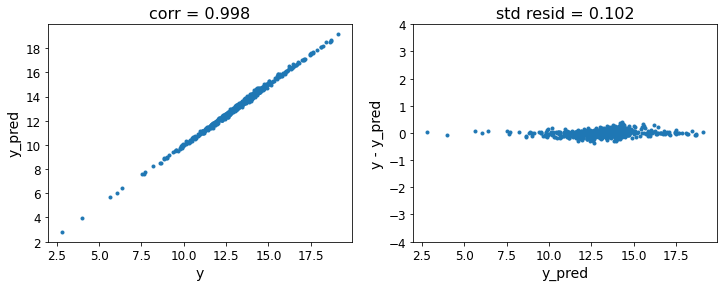

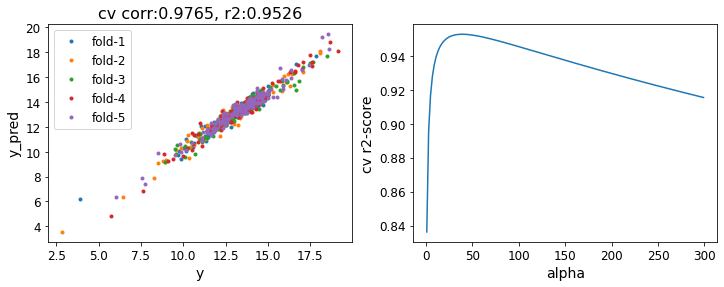

EBI -  Drug: ERLOTINIB, N_genes: 10
Fitting 25 folds for each of 150 candidates, totalling 3750 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.4s


----------------------
Ridge(alpha=63, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3743 out of 3750 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 3750 out of 3750 | elapsed:    4.6s finished


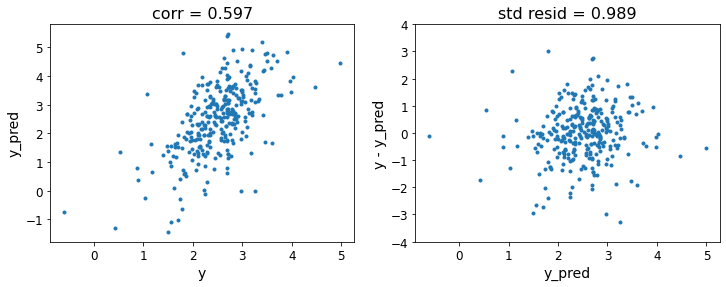

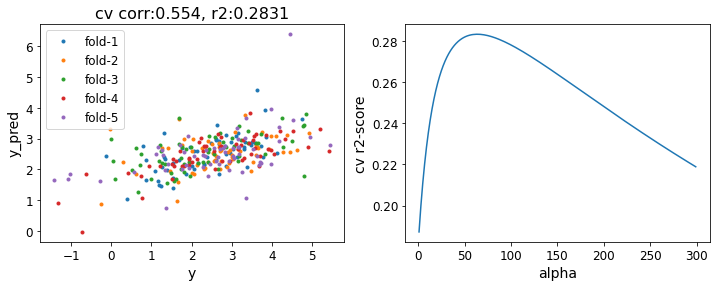

EBI -  Drug: ERLOTINIB, N_genes: 39
Fitting 25 folds for each of 150 candidates, totalling 3750 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.5s


----------------------
Ridge(alpha=45, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3743 out of 3750 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 3750 out of 3750 | elapsed:    4.8s finished


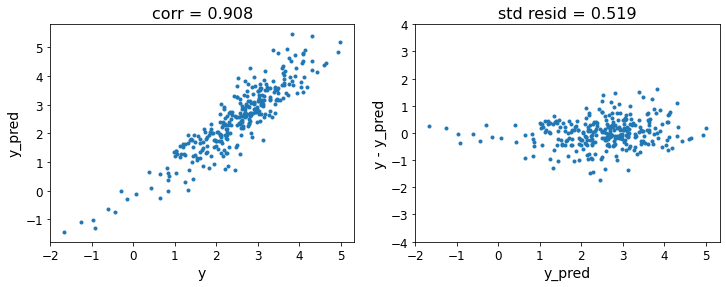

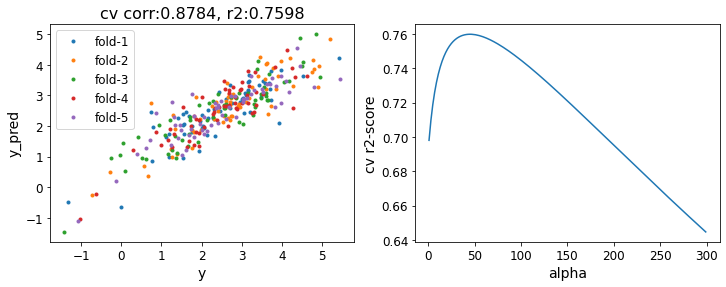

EBI -  Drug: ERLOTINIB, N_genes: 69
Fitting 25 folds for each of 150 candidates, totalling 3750 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.4s


----------------------
Ridge(alpha=45, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3750 out of 3750 | elapsed:    5.0s finished


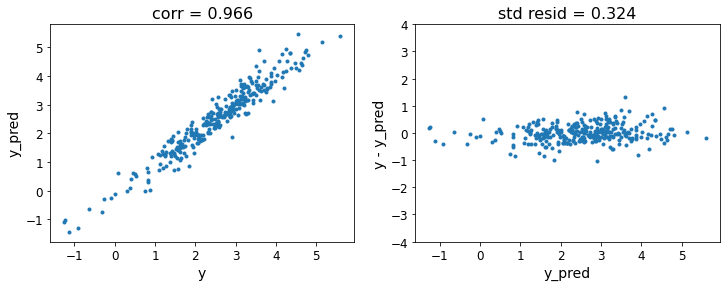

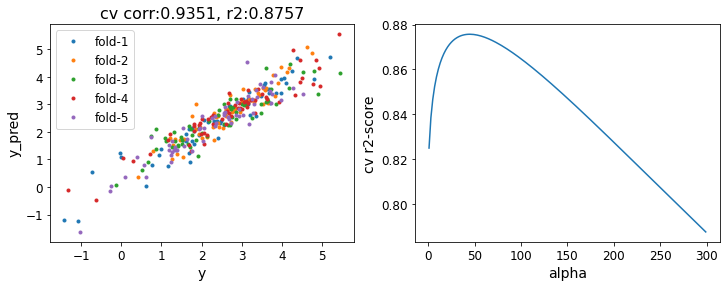

EBI -  Drug: ERLOTINIB, N_genes: 98
Fitting 25 folds for each of 150 candidates, totalling 3750 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.3s


----------------------
Ridge(alpha=25, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3743 out of 3750 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 3750 out of 3750 | elapsed:    5.0s finished


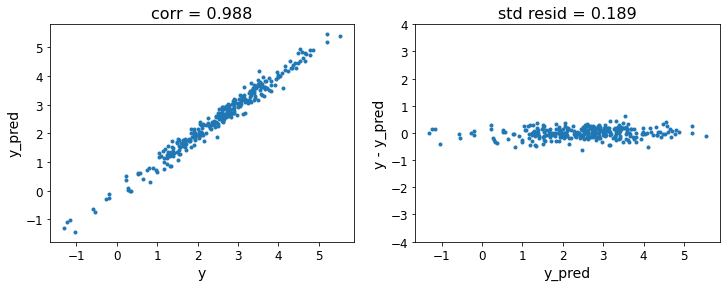

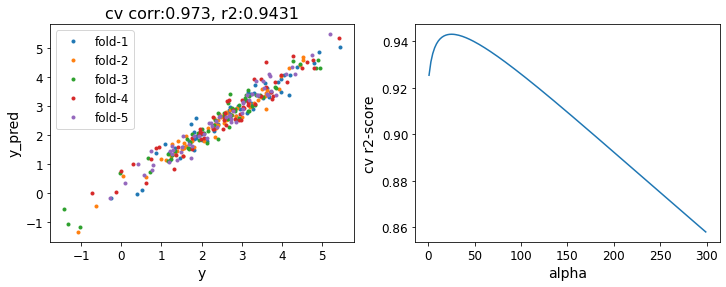

EBI -  Drug: ERLOTINIB, N_genes: 128
Fitting 25 folds for each of 150 candidates, totalling 3750 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.5s


----------------------
Ridge(alpha=15, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3743 out of 3750 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 3750 out of 3750 | elapsed:    5.4s finished


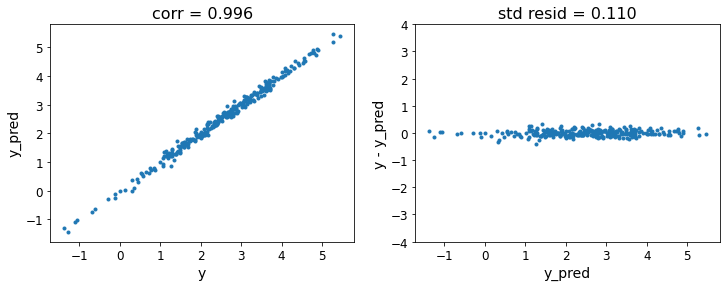

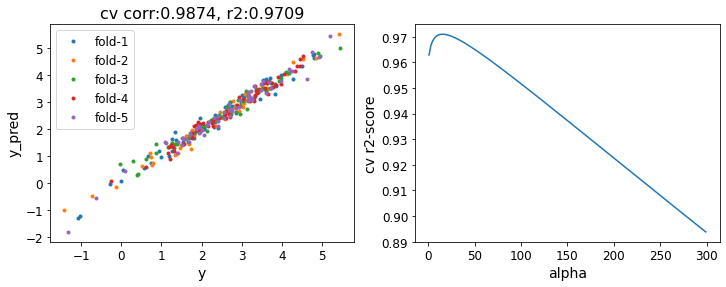

EBI -  Drug: ERLOTINIB, N_genes: 157
Fitting 25 folds for each of 150 candidates, totalling 3750 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.3s


----------------------
Ridge(alpha=15, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3743 out of 3750 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 3750 out of 3750 | elapsed:    5.4s finished


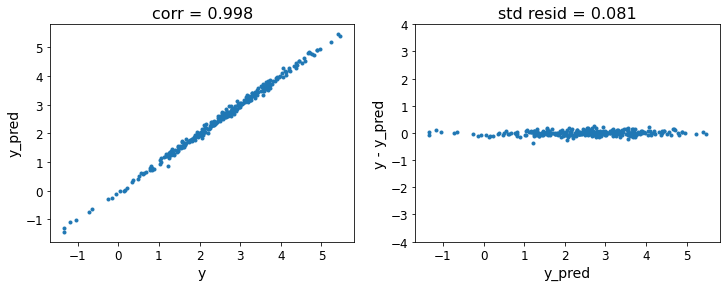

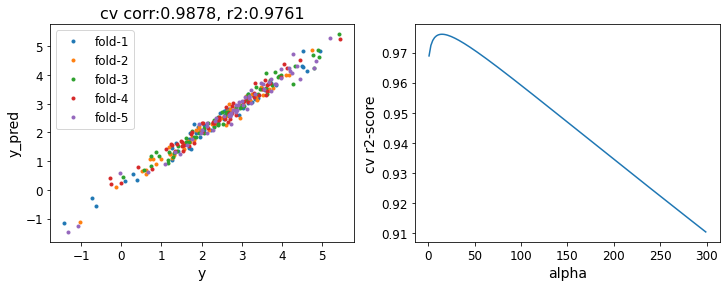

EBI -  Drug: ERLOTINIB, N_genes: 187
Fitting 25 folds for each of 150 candidates, totalling 3750 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    1.5s


----------------------
Ridge(alpha=9, copy_X=True, fit_intercept=True, max_iter=10000, normalize=False,
      random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3750 out of 3750 | elapsed:    6.0s finished


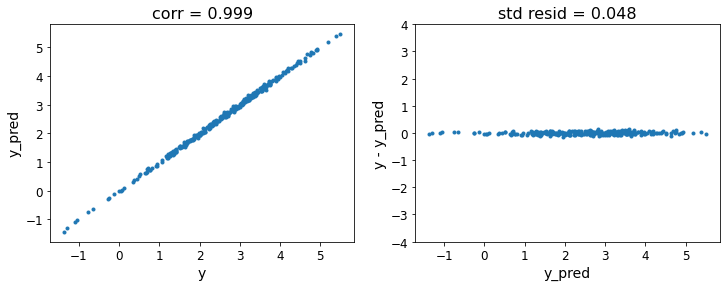

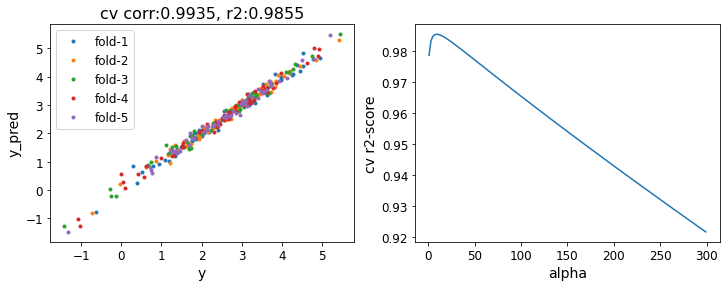

EBI -  Drug: ERLOTINIB, N_genes: 216
Fitting 25 folds for each of 150 candidates, totalling 3750 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.4s


----------------------
Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=10000, normalize=False,
      random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3750 out of 3750 | elapsed:    6.3s finished


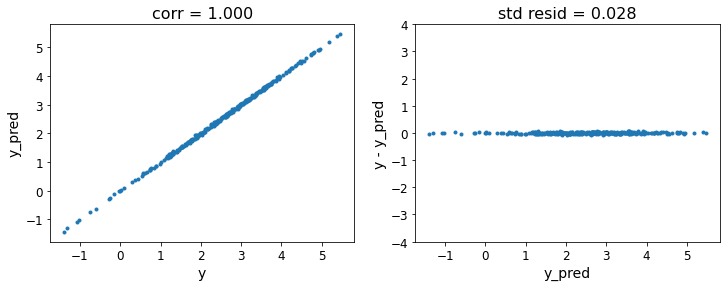

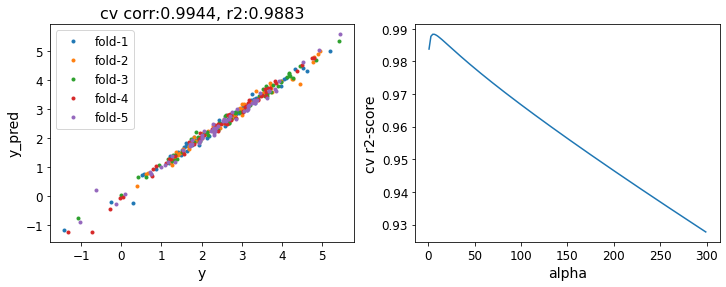

EBI -  Drug: ERLOTINIB, N_genes: 246
Fitting 25 folds for each of 150 candidates, totalling 3750 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.6s


----------------------
Ridge(alpha=3, copy_X=True, fit_intercept=True, max_iter=10000, normalize=False,
      random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3750 out of 3750 | elapsed:    7.1s finished


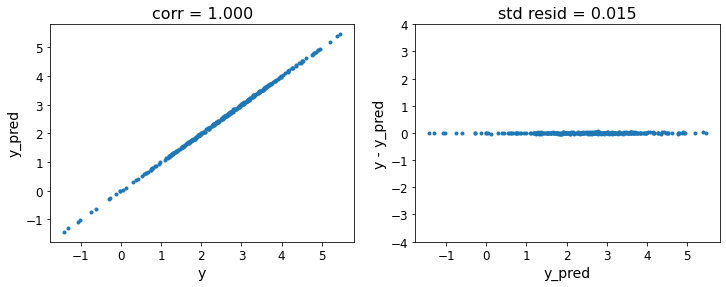

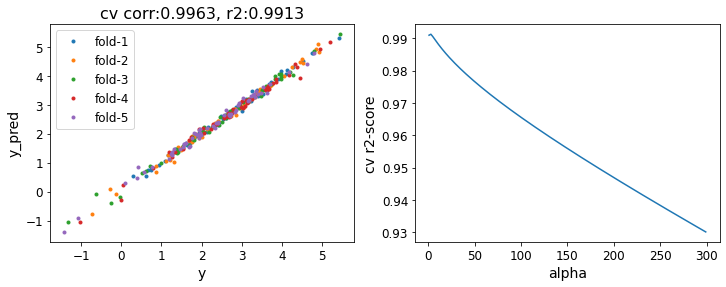

EBI -  Drug: ERLOTINIB, N_genes: 275
Fitting 25 folds for each of 150 candidates, totalling 3750 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.4s


----------------------
Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=10000, normalize=False,
      random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3750 out of 3750 | elapsed:    7.3s finished


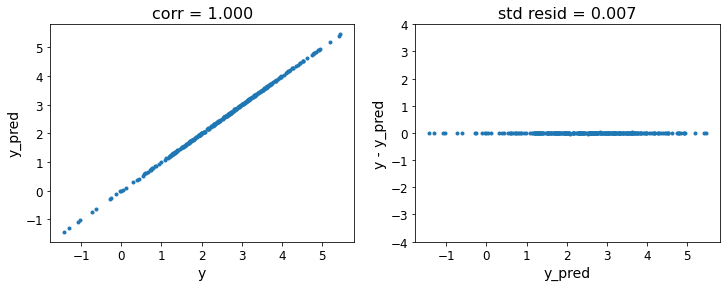

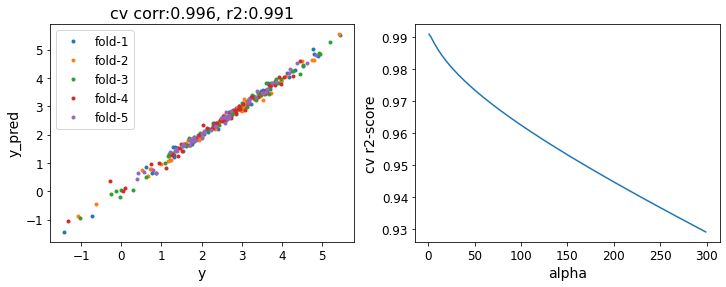

EBI -  Drug: ERLOTINIB, N_genes: 305
Fitting 25 folds for each of 150 candidates, totalling 3750 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.4s


----------------------
Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=10000, normalize=False,
      random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3750 out of 3750 | elapsed:    7.5s finished


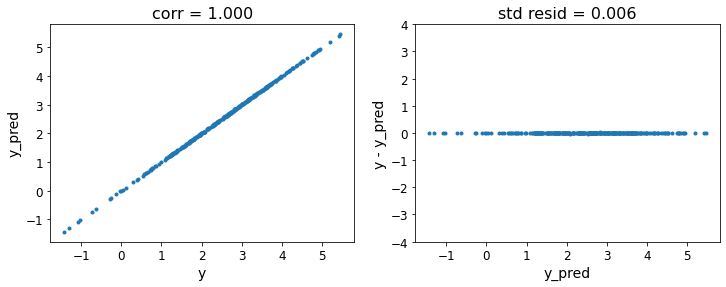

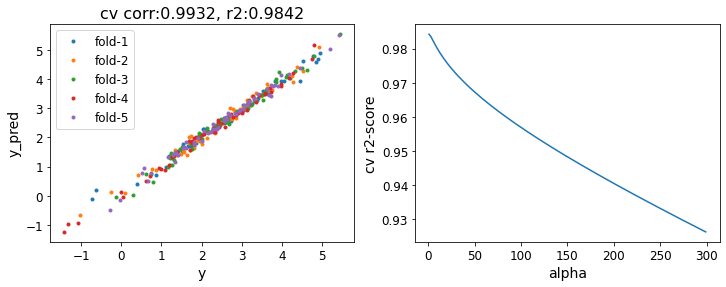

EBI -  Drug: ERLOTINIB, N_genes: 335
Fitting 25 folds for each of 150 candidates, totalling 3750 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.4s


----------------------
Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=10000, normalize=False,
      random_state=None, solver='auto', tol=0.001)
----------------------


[Parallel(n_jobs=4)]: Done 3750 out of 3750 | elapsed:    7.7s finished


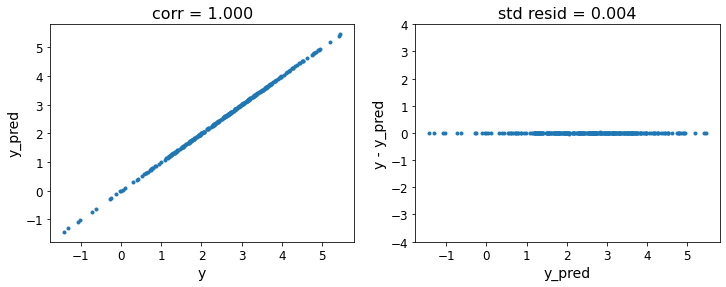

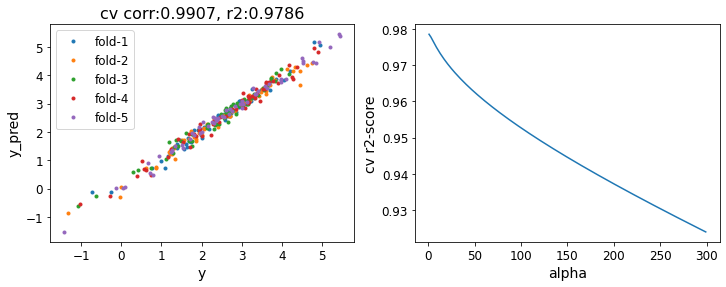

In [30]:
splits = 5
repeats = 5

cv_r2_tmp = []

model = Ridge(max_iter=10000)
alph_range = np.arange(1,300,2)
param_grid = {'alpha': alph_range}

cnt = 0
for drug in drug_list:
    cnt +=1
    print('current step {} / total {}'.format(cnt, len(drug_list)))
    
    mask1 = ~df_ctrp.loc[:,drug].isna()
    ctrp_x =  df_ctrp[mask1].iloc[:,:Ngenes]
    out = scaler.fit_transform(ctrp_x)
    ctrp_x = pd.DataFrame(out, columns=ctrp_x.columns, index=list(ctrp_x.index.values))
    ctrp_y = df_ctrp[mask1].loc[:,drug]
    
    ctrp_sgenes = list(ctrp_genes_df[drug])
    print("ctrp original features length = {}".format(len(ctrp_sgenes)))
    ctrp_x = ctrp_x.loc[:,ctrp_sgenes]
    ctrp_poly_values = poly.fit_transform(ctrp_x)
    ctrp_poly_columns =poly.get_feature_names(ctrp_sgenes)
    print("with interactions => {}".format(len(ctrp_poly_columns)-1))
    ctrp_poly = pd.DataFrame(ctrp_poly_values[:,1:],columns=ctrp_poly_columns[1:] ,index=ctrp_x.index)
    ctrp_single_term = ctrp_poly.iloc[:,:len(ctrp_sgenes)]
    ctrp_cross_term = ctrp_poly.iloc[:,len(ctrp_sgenes):]
    scaling_values = scaler.fit_transform(ctrp_cross_term)
    ctrp_cross_term = pd.DataFrame(scaling_values, columns=ctrp_cross_term.columns, index=list(ctrp_cross_term.index.values))
    ctrp_poly = pd.merge(ctrp_single_term, ctrp_cross_term, left_index=True, right_index=True, how='left')
    mask = ~df_sorted_genes[drug+'-ctrp'].isna()
    ctrp_genes_all = list(df_sorted_genes[mask][drug+'-ctrp'])
    ctrp_loop = np.linspace(10,len(ctrp_genes_all),12, dtype=int)
    

    mask2 = ~df_ebi.loc[:,drug].isna()
    ebi_x =  df_ebi[mask2].iloc[:,:Ngenes]
    out = scaler.fit_transform(ebi_x)
    ebi_x = pd.DataFrame(out, columns=ebi_x.columns, index=list(ebi_x.index.values))
    ebi_y = df_ebi[mask2].loc[:,drug]

    ebi_sgenes = list(ebi_genes_df[drug])
    print("ebi original features length = {}".format(len(ebi_sgenes)))
    ebi_x = ebi_x.loc[:,ebi_sgenes]
    ebi_poly_values = poly.fit_transform(ebi_x)
    ebi_poly_columns =poly.get_feature_names(ebi_sgenes)
    print("with interactions => {}".format(len(ebi_poly_columns)-1))
    ebi_poly = pd.DataFrame(ebi_poly_values[:,1:],columns=ebi_poly_columns[1:] ,index=ebi_x.index)
    ebi_single_term = ebi_poly.iloc[:,:len(ebi_sgenes)]
    ebi_cross_term = ebi_poly.iloc[:,len(ebi_sgenes):]
    scaling_values = scaler.fit_transform(ebi_cross_term)
    ebi_cross_term = pd.DataFrame(scaling_values, columns=ebi_cross_term.columns, index=list(ebi_cross_term.index.values))
    ebi_poly = pd.merge(ebi_single_term, ebi_cross_term, left_index=True, right_index=True, how='left')
    mask = ~df_sorted_genes[drug+'-ebi'].isna()
    ebi_genes_all = list(df_sorted_genes[mask][drug+'-ebi'])
    ebi_loop = np.linspace(10,len(ebi_genes_all),12, dtype=int)
    
    for Num_genes in ctrp_loop:
        print("CTRP -  Drug: {}, N_genes: {}".format(drug, Num_genes))
        
        selected_Genes = ctrp_genes_all[:Num_genes]
        ctrp_poly_sel = ctrp_poly.loc[:,selected_Genes]
        best_model,cv_score,grid_results = train_model(model, param_grid=param_grid, \
                                                       splits=splits, repeats=repeats, X=ctrp_poly_sel, y=ctrp_y)
        cv_r2 = cv_score['mean']
        cv_r2 = np.around(cv_r2,4)
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        y_pred_list, y_true_list, y_pred, y = get_cross_val_prediction(best_model,X=ctrp_poly_sel,y=ctrp_y)
        corr = np.corrcoef(x=y_pred, y=y)
        corr = np.around(corr[0,1],4)
        plt.plot(y_true_list[0],y_pred_list[0],'.',label='fold-1')
        plt.plot(y_true_list[1],y_pred_list[1],'.',label='fold-2')
        plt.plot(y_true_list[2],y_pred_list[2],'.',label='fold-3')
        plt.plot(y_true_list[3],y_pred_list[3],'.',label='fold-4')
        plt.plot(y_true_list[4],y_pred_list[4],'.',label='fold-5')
        plt.legend()
        plt.xlabel('y')
        plt.ylabel('y_pred')
        plt.title('cv corr:{}, r2:{}'.format(corr,cv_r2))
        plt.subplot(1,2,2)
        plt.plot(alph_range, abs(grid_results['mean_test_score']))
        plt.xlabel('alpha')
        plt.ylabel('cv r2-score')
        plt.show()
        cv_r2_df.loc[Num_genes,drug+'-ctrp'] = cv_r2
        
        f_name = 'SI-CCLE-{}-{}.csv'.format(drug,Num_genes)
        df = pd.DataFrame(columns=['y_hat','y'])
        df['y_hat'] = y_pred
        df['y'] = y
        df.to_csv(f_name)
        
    
    for Num_genes in ebi_loop:
        print("EBI -  Drug: {}, N_genes: {}".format(drug, Num_genes))
        
        selected_Genes = ebi_genes_all[:Num_genes]
        ebi_poly_sel = ebi_poly.loc[:,selected_Genes]
        best_model,cv_score,grid_results = train_model(model, param_grid=param_grid, \
                                                       splits=splits, repeats=repeats, X=ebi_poly_sel, y=ebi_y)
        cv_r2 = cv_score['mean']
        cv_r2 = np.around(cv_r2,4)
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        y_pred_list, y_true_list, y_pred, y = get_cross_val_prediction(best_model,X=ebi_poly_sel,y=ebi_y)
        corr = np.corrcoef(x=y_pred, y=y)
        corr = np.around(corr[0,1],4)
        plt.plot(y_true_list[0],y_pred_list[0],'.',label='fold-1')
        plt.plot(y_true_list[1],y_pred_list[1],'.',label='fold-2')
        plt.plot(y_true_list[2],y_pred_list[2],'.',label='fold-3')
        plt.plot(y_true_list[3],y_pred_list[3],'.',label='fold-4')
        plt.plot(y_true_list[4],y_pred_list[4],'.',label='fold-5')
        plt.legend()
        plt.xlabel('y')
        plt.ylabel('y_pred')
        plt.title('cv corr:{}, r2:{}'.format(corr,cv_r2))
        plt.subplot(1,2,2)
        plt.plot(alph_range, abs(grid_results['mean_test_score']))
        plt.xlabel('alpha')
        plt.ylabel('cv r2-score')
        plt.show()
        cv_r2_df.loc[Num_genes,drug+'-ebi'] = cv_r2
        
        f_name = 'SI-GDSC-{}-{}.csv'.format(drug,Num_genes)
        df = pd.DataFrame(columns=['y_hat','y'])
        df['y_hat'] = y_pred
        df['y'] = y
        df.to_csv(f_name)
        
    


In [31]:
f = 'cv_r2_eachdata_tdrug_new_lasso.csv'
cv_r2_df.to_csv(f,na_rep=np.nan)

In [32]:
f = 'cv_r2_eachdata_tdrug_new_lasso.csv'
cv_r2_df = pd.read_csv(f,index_col=0)

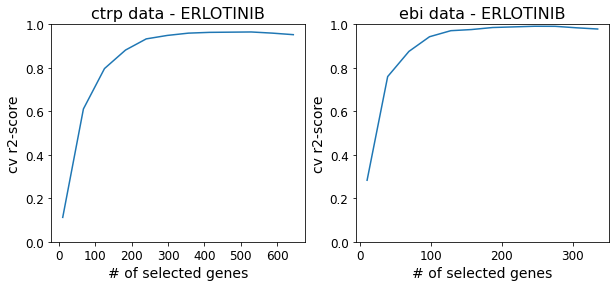

In [33]:
for drug in drug_list:
    
    
    m1 = ~cv_r2_df[drug+'-ctrp'].isna()
    N_used_genes = list(cv_r2_df[m1][drug+'-ctrp'].index)
    ctrp_res = list(cv_r2_df[m1][drug+'-ctrp'])
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(N_used_genes, ctrp_res)
    plt.ylim((0,1))
    plt.xlabel('# of selected genes')
    plt.ylabel('cv r2-score')
    plt.title('ctrp data - {}'.format(drug))
    plt.subplot(1,2,2)
    
    m2 = ~cv_r2_df[drug+'-ebi'].isna()
    N_used_genes = list(cv_r2_df[m2][drug+'-ebi'].index)
    ebi_res = list(cv_r2_df[m2][drug+'-ebi'])
   
    plt.plot(N_used_genes, ebi_res)
    plt.ylim((0,1))
    plt.xlabel('# of selected genes')
    plt.ylabel('cv r2-score')
    plt.title('ebi data - {}'.format(drug))